In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import tree
from sklearn.neural_network import MLPClassifier
! pip install lime
import lime
from lime import lime_tabular
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import scipy as sp
import sklearn
import os
from scipy.optimize import minimize
import gurobipy as gp
from gurobipy import GRB
import simpy as sp
import math
import warnings

#Import Data Generation Processes
from SCM import ScalarLinearDecisionModel, NewScalarLinearDecisionModel, SelectionBiasDecisionModel

#Import Helper Functions
import graph_helper as graph#line_plots, importance_heatmap, diff_importance_heatmap, categorical_heatmap
import logger_helper as logger #find_pred_improve_lin_cost, find_real_improve_lin_cost
import optimization_helper as opt #find_pred_improve_lin_cost, find_real_improve_lin_cost

# Equal Improvability

## Fairness Metrics Function

In [2]:
def new_fairness_violation(SCM, trainer, SCM_params, sim_params):
  """
    Calculate new proposed metrics related to Equal Improvability (EI) measure, varying two parameters 
    in order to make heatmaps using optimization.

    Args:
        data_gen_process: Data generation process for the model
        trainer: The trained model used for prediction.
        trials (int): Number of trials to simulate to collect data.
        params (dict): Parameters for the data generation model.
        deltas (numpy.ndarray): Array of different effort change, delta.
        cost_fn (dict): Cost function with weights and bias.
        str_vars (str): String representing the variable name for the the coefficients that are varied.
        vars_0 (numpy.ndarray): Array of variable values to be used to vary the first coefficient.
        vars_1 (numpy.ndarray): Array of variable values to be used to vary the second coefficient.

    Returns:
        dict: A dictionary containing the following calculated metrics:
            - gaming: Array containing the gaming metric for each set of different parameters. 
            - improve_data: Array containing the improvement metric for each set of different parameters.
            - best_feature_improved: Array of 1 where C was better to improve -1 where A was better improve, and 0 if equal.
            - pred_accuracy: Array of prediction accuracy for each set of parameters.
            - feature_weights_AC: Array of feature weights for each set of parameters.
  """

  #Initialize variables to collect data
  dim_data = (sim_params["trials"], sim_params["deltas"].shape[0], sim_params["vars_0"].shape[0], sim_params["vars_1"].shape[0], 2)
  dim_data_U = (sim_params["trials"], sim_params["deltas"].shape[0], sim_params["vars_0"].shape[0], sim_params["vars_1"].shape[0], 2, 2)
  dim_data_wo_d = (sim_params["trials"], sim_params["vars_0"].shape[0], sim_params["vars_1"].shape[0], 2)
  dim_data_features = (sim_params["trials"], SCM_params['input_dim'], sim_params["deltas"].shape[0], sim_params["vars_0"].shape[0], sim_params["vars_1"].shape[0], 2)
  dim_data_features_wo_d = (sim_params["trials"], SCM_params['input_dim'], sim_params["vars_0"].shape[0], sim_params["vars_1"].shape[0], 2)
  ei_data = np.zeros(dim_data)*np.nan
  improve_data = np.zeros(dim_data)*np.nan
  gaming_data = np.zeros(dim_data)*np.nan
  improve_data_U = np.zeros(dim_data_U)*np.nan
  gaming_data_U = np.zeros(dim_data_U)*np.nan
  pred_improvable_labels = np.zeros(dim_data)*np.nan
  pred_improvable_features = np.zeros(dim_data_features)*np.nan
  real_improvable_labels = np.zeros(dim_data)*np.nan
  real_improvable_features = np.zeros(dim_data_features)*np.nan
  pred_delta_too_high = np.zeros(dim_data)*np.nan
  pred_accuracy = np.zeros((sim_params["trials"], sim_params["vars_0"].shape[0], sim_params["vars_1"].shape[0]))*np.nan
  pred_feature_weights = np.zeros(dim_data_features_wo_d[:-1])*np.nan
  pred_feature_improved = np.zeros(dim_data_wo_d)*np.nan
  real_feature_improved = np.zeros(dim_data_wo_d)*np.nan
  pred_delta_improv = np.zeros(dim_data_wo_d)*np.nan
  real_delta_improv = np.zeros(dim_data_wo_d)*np.nan
  covariance_A_Y = np.zeros(dim_data_wo_d)*np.nan
  covariance_C_Y = np.zeros(dim_data_wo_d)*np.nan
  covariance_U_Y = np.zeros(dim_data_wo_d)*np.nan
  #Initialize simulation
  for i, var_0 in enumerate(sim_params["vars_0"]):
    for j, var_1 in enumerate(sim_params["vars_1"]):
      #print("var 0: ", var_0, " and var 1: ", var_1) 
      for trial in range(sim_params["trials"]):
        #Generate Data
        SCM_params[sim_params["str_vars"][0]] = var_0
        SCM_params[sim_params["str_vars"][1]] = var_1
        data_train = SCM(SCM_params)
        data_train.generate_basic_data()
        data_train_pd = data_train.get_data_df()
        data_train_features = data_train.get_features()
        model = trainer.fit(data_train_features[data_train.mask], data_train_pd["Y"][data_train.mask])
        data_test = data_train
        data_summary = data_test.get_data_df()
        data_test_features = data_test.get_features()
        pred_y = model.predict(data_test_features)
        pred_accuracy[trial, i, j] = model.score(data_test_features, data_summary["Y"])
        pred_feature_weights[trial, :, i, j] = (model.coef_[0])
        pred_fn = {'w': model.coef_.flatten(), 'b': model.intercept_[0]} 
        mask = np.array([data_summary["S"] == 0, data_summary["S"] == 1])
        #mask_maj = 
        #if we have some unqualified majority members, we can collect data
        if len(data_summary['S'][mask[1] & (data_summary['Y'] == 0)]) == 0:
          print("FAILED trial: ", trial, " with var 0: ", var_0, " and var 1: ", var_1)
        else:
          #print("SUCCEEDED trial: ", trial, " with var 1: ", var_1, " and var 2: ", var_2)
          pred_best_delta, pred_best_improvement, pred_which_improve = opt.find_pred_improve_lin_cost(data_test, sim_params["cost_fn"], pred_fn, data_summary)
          real_best_delta, real_best_improvement, real_which_improve = opt.find_real_improve_lin_cost(data_test, sim_params["cost_fn"], data_summary)
          #Collect data for each group
          for group in range(2):
            pred_delta_improv[trial, i, j, group] = np.mean(pred_best_delta[mask[group]])
            real_delta_improv[trial, i, j, group] = np.mean(real_best_delta[mask[group]])
            pred_feature_improved[trial, i, j, group] = np.mean(pred_which_improve[(mask[group]) & (pred_y == 0)])
            real_feature_improved[trial, i, j, group] = np.mean(real_which_improve[(mask[group]) & (pred_y == 0)])
            covariance_A_Y[trial, i, j, group] = np.mean(np.cov(np.stack((data_test.A[mask[group]], data_test.Y[mask[group]]), axis = 0)))
            covariance_C_Y[trial, i, j, group] = np.mean(np.cov(np.stack((data_test.C[mask[group]], data_test.Y[mask[group]]), axis = 0)))
            
            if hasattr(data_summary, 'U') and data_test.U is not None:
              covariance_U_Y[trial, i, j, group] = np.mean(np.cov(np.stack((data_test.U[mask[group]], data_test.Y[mask[group]]), axis = 0)))
          if (np.sum(pred_best_improvement[(mask[0]) & (pred_y == 0)], axis=0)[0] > 0 and np.sum(pred_best_improvement[(mask[0]) & (pred_y == 0)], axis=0)[1] > 0
             or np.sum(pred_best_improvement[(mask[1]) & (pred_y == 0)], axis=0)[0] > 0 and np.sum(pred_best_improvement[(mask[1]) & (pred_y == 0)], axis=0)[1] > 0):
            print("var 1: ", var_1, " and var 2: ", var_2)   
            print("minority ", np.sum(pred_best_improvement[(mask[0]) & (pred_y == 0)], axis=0))
            print("majority ", np.sum(pred_best_improvement[(mask[1]) & (pred_y == 0)], axis=0))
          for d, delta in enumerate(sim_params["deltas"]):
            for group in range(2):
              #Collect average number of people who needed less than delta in reality but needed more than delta for the prediction
              pred_delta_too_high[trial, d, i, j, group] = np.mean(np.where((real_best_delta[mask[group]] <= delta) & (pred_best_delta[mask[group]] > delta), 1, 0))
            
              #Collect avgerage label of improvable people without the improvement
              pred_improvable_labels[trial, d, i, j, group] = np.mean(pred_y[(real_best_delta <= delta) & (data_summary['Y_logit'] < 0) & (mask[group])])
              pred_improvable_features[trial, :, d, i, j, group] = np.mean(data_test_features[(real_best_delta <= delta) & (data_summary['Y_logit'] < 0) & (mask[group])])
              real_improvable_labels[trial, d, i, j, group] = np.mean(np.where(data_summary["Y_logit"][(pred_best_delta <= delta) & (pred_y == 0) & (mask[group])] >= 0, 1, 0))
              real_improvable_features[trial, :, d, i, j, group] = np.mean(data_test_features[(pred_best_delta <= delta) & (pred_y == 0) & (mask[group])])
            if delta == 0.1:
              if False:
                print(pred_improvable_labels[trial, d, i, j, 0])
                print("number of minority members", len(pred_y[(mask[0])]))
                print("number of minority members with negative real expected label ", len(pred_y[((data_summary['Y_logit'] < 0) & (mask[0]))]))
                print("number of minority members with negative real expected label and more than delta effort", len(pred_y[((real_best_delta <= delta) & (data_summary['Y_logit'] < 0) & (mask[0]))]))
                print("labels ", pred_y[((real_best_delta <= delta) & (data_summary['Y_logit'] < 0) & (mask[0]))])
              
            #Collect EI data: P(f_hat(x + delta_hat_x) >= 0.5 | f_hat(x) < 0.5)
            f_results_ei =  np.where(pred_best_delta[pred_y == 0] <= delta, 1, 0)
            
            ei_data[trial, d, i, j, 0] = np.mean(f_results_ei[data_summary["S"][pred_y == 0] == 0])
            ei_data[trial, d, i, j, 1] = np.mean(f_results_ei[data_summary["S"][pred_y == 0] == 1])
            
            #Collect Gaming data: P(f_hat(x + delta_hat_x) >= 0.5 | f(x) < 0.5, f(x + delta_hat_x) < 0.5 )
            pred_best_improvement_delta = np.zeros_like(pred_best_improvement)
            pred_best_improvement_delta[pred_best_delta <= delta] = pred_best_improvement[pred_best_delta <= delta]
            f_results_g = data_test.generate_y_logit(data = data_summary.loc[data_summary['Y_logit'] < 0], 
                                                     diff_vec = pred_best_improvement_delta[data_summary['Y_logit'] < 0])

            #filtered_pred_improvement = pred_best_improvement_delta[f_results_g == 0]
            gaming_pred = np.where(pred_best_delta[data_summary['Y_logit'] < 0][f_results_g < 0] <= delta,1,0)
            #gaming_pred = model.predict(data_unqualified['AC'][f_results_g == 0] + filtered_pred_improvement[f_results_g == 0])
            filtered_S_g = data_summary['S'][data_summary['Y_logit'] < 0][f_results_g < 0]
            filtered_U_g = data_summary['U'][data_summary['Y_logit'] < 0][f_results_g < 0]
            #print(np.mean(f_results_g))
            #print(np.mean(gaming_pred))
            gaming_data[trial, d, i, j, 0] = np.mean(gaming_pred[filtered_S_g == 0])
            gaming_data[trial, d, i, j, 1] = np.mean(gaming_pred[filtered_S_g == 1])
            gaming_data_U[trial, d, i, j, 0, 0] = np.mean(gaming_pred[(filtered_U_g == 0) & (filtered_S_g == 0)])
            gaming_data_U[trial, d, i, j, 0, 1] = np.mean(gaming_pred[(filtered_U_g == 0) & (filtered_S_g == 1)])
            gaming_data_U[trial, d, i, j, 1, 0] = np.mean(gaming_pred[(filtered_U_g == 1) & (filtered_S_g == 0)])
            gaming_data_U[trial, d, i, j, 1, 1] = np.mean(gaming_pred[(filtered_U_g == 1) & (filtered_S_g == 1)])
            
            # Collect Improvment data: P(f(x + delta_hat_x) >= 0.5 | f(x) < 0.5, f(x + delta_x) >= 0.5)
            filtered_S_i = data_summary['S'][(real_best_delta <= delta) & (data_summary['Y_logit'] < 0)]
            filtered_U_i = data_summary['U'][(real_best_delta <= delta) & (data_summary['Y_logit'] < 0)]
            f_results_i = data_test.generate_y_logit(data = data_summary.loc[(real_best_delta <= delta) & (data_summary['Y_logit'] < 0)], 
                                                    diff_vec = pred_best_improvement[(real_best_delta <= delta) & (data_summary['Y_logit'] < 0)])
            
            improv_results = np.where(f_results_i >= 0, 1, 0) 
        
            improve_data[trial, d, i, j, 0] = np.mean(improv_results[filtered_S_i == 0])
            improve_data[trial, d, i, j, 1] = np.mean(improv_results[filtered_S_i == 1])
            improve_data_U[trial, d, i, j, 0, 0] = np.mean(improv_results[(filtered_U_i == 0) & (filtered_S_i == 0)])
            improve_data_U[trial, d, i, j, 0, 1] = np.mean(improv_results[(filtered_U_i == 0) & (filtered_S_i == 1)])
            improve_data_U[trial, d, i, j, 1, 0] = np.mean(improv_results[(filtered_U_i == 1) & (filtered_S_i == 0)])
            improve_data_U[trial, d, i, j, 1, 1] = np.mean(improv_results[(filtered_U_i == 1) & (filtered_S_i == 1)])
            
         
      #print("var 1: ", var_1, " and var 2: ", var_2)
  #print(pred_improvable_labels)
  results = {
      "ei_data": np.where(np.isnan(ei_data).sum(axis=0) < ei_data.shape[0]*3/4, np.nanmean(ei_data, axis=0), np.nan), 
      "gaming_data": np.where(np.isnan(gaming_data).sum(axis=0) < gaming_data.shape[0]*3/4, np.nanmean(gaming_data, axis=0), np.nan), 
      "improve_data": np.where(np.isnan(improve_data).sum(axis=0) < improve_data.shape[0]*3/4, np.nanmean(improve_data, axis=0), np.nan),  
      "gaming_data_U": np.where(np.isnan(gaming_data_U).sum(axis=0) < gaming_data_U.shape[0]*3/4, np.nanmean(gaming_data_U, axis=0), np.nan), 
      "improve_data_U": np.where(np.isnan(improve_data_U).sum(axis=0) < improve_data_U.shape[0]*3/4, np.nanmean(improve_data_U, axis=0), np.nan),  
      "pred_accuracy": np.where(np.isnan(pred_accuracy).sum(axis=0) < pred_accuracy.shape[0]*3/4, np.nanmean(pred_accuracy, axis=0), np.nan), 
      "pred_feature_weights": np.where(np.isnan(pred_feature_weights).sum(axis=0) < pred_feature_weights.shape[0]*3/4, np.nanmean(pred_feature_weights, axis=0), np.nan),
      "pred_feature_improved": np.where(np.isnan(pred_feature_improved).sum(axis=0) < pred_feature_improved.shape[0]*3/4, np.nanmean(pred_feature_improved, axis=0), np.nan), 
      "real_feature_improved": np.where(np.isnan(real_feature_improved).sum(axis=0) < real_feature_improved.shape[0]*3/4, np.nanmean(real_feature_improved, axis=0), np.nan),
      "pred_delta_improv": np.where(np.isnan(pred_delta_improv).sum(axis=0) < pred_delta_improv.shape[0]*3/4, np.nanmean(pred_delta_improv, axis=0), np.nan),
      "real_delta_improv": np.where(np.isnan(real_delta_improv).sum(axis=0) < real_delta_improv.shape[0]*3/4, np.nanmean(real_delta_improv, axis=0), np.nan),
      "pred_improvable_labels": np.where(np.isnan(pred_improvable_labels).sum(axis=0) < pred_improvable_labels.shape[0]*3/4, np.nanmean(pred_improvable_labels, axis=0), np.nan),
      "pred_improvable_features": np.where(np.isnan(pred_improvable_features).sum(axis=0) < pred_improvable_features.shape[0]*3/4, np.nanmean(pred_improvable_features, axis=0), np.nan),
      "real_improvable_labels": np.where(np.isnan(real_improvable_labels).sum(axis=0) < real_improvable_labels.shape[0]*3/4, np.nanmean(real_improvable_labels, axis=0), np.nan),
      "real_improvable_features": np.where(np.isnan(real_improvable_features).sum(axis=0) < real_improvable_features.shape[0]*3/4, np.nanmean(real_improvable_features, axis=0), np.nan),
      "pred_delta_too_high": np.where(np.isnan(pred_delta_too_high).sum(axis=0) < pred_delta_too_high.shape[0]*3/4, np.nanmean(pred_delta_too_high, axis=0), np.nan),
      "covariance_A_Y": np.where(np.isnan(covariance_A_Y).sum(axis=0) < covariance_A_Y.shape[0]*3/4, np.nanmean(covariance_A_Y, axis=0), np.nan),
      "covariance_C_Y": np.where(np.isnan(covariance_C_Y).sum(axis=0) < covariance_C_Y.shape[0]*3/4, np.nanmean(covariance_C_Y, axis=0), np.nan),
      "covariance_U_Y": np.where(np.isnan(covariance_U_Y).sum(axis=0) < covariance_U_Y.shape[0]*3/4, np.nanmean(covariance_U_Y, axis=0), np.nan),
  }
  return results




# CURRENT RUNS

In [3]:
default_params = {
    'n_samples': 1000, 
    'input_dim': 2,
    'intervention_dim': 2,
    'p_majority': 0.5,
    's_u_const': 0,
    'u_var': 1,
    's_a_const': 1, 
    'u_a_const': 1,
    'a_var': 1, 
    's_c_const': 0,  
    'a_c_const': 1, 
    'c_var': 1, 
    's_y_const': 1, 
    'c_y_const': 1,
    'u_y_const': 1,
    'y_var': 0.1,
    
}

labels = {
    's_u_const': r"$\beta$ (S$\rightarrow$U)",
    's_a_const': r"$\alpha_S$ (S$\rightarrow$A)", 
    's_c_const': r"$\omega_S$ (S$\rightarrow$C)",  
    'a_c_const': r"$\omega_A$ (A$\rightarrow$C)", 
    's_y_const': r"$m_S$ (S$\rightarrow$Y)", 
    'c_y_const': r"$m_C$ (C$\rightarrow$Y)",
    'u_a_const': r"$\alpha_U$ (U$\rightarrow$A)",
    'u_y_const': r"$m_U$ (U$\rightarrow$Y)",
}


In [4]:
simulation_params = {
  "trials": 5,
  "str_vars": np.array(["u_a_const", "u_y_const"]),
  "vars_0": np.arange(0, 4, 0.25),
  "vars_1": np.arange(0, 4, 0.25),
  "deltas": np.array([0.1, 0.25, 0.5, 1, 2, 2.5]),
  "cost_fn": {'w': np.array([1, 1]),'b': 0},
}

In [5]:
all_params = default_params.copy()
all_params.update(simulation_params)
graph_folder = logger.initialize_graph_folder(all_params)
simulation_params["graph_folder"] = graph_folder

with warnings.catch_warnings():
  warnings.filterwarnings("ignore", category=RuntimeWarning, message="Mean of empty slice")
  warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in double_scalars")

  ei_data_test = new_fairness_violation(SCM = NewScalarLinearDecisionModel, 
                                        trainer = LogisticRegression(),
                                        SCM_params = default_params.copy(), 
                                        sim_params = simulation_params.copy())

logger.save_sim_data(folder_name = graph_folder, sim_data = ei_data_test)

Folder 'graphs_07-11-2023_00-01-31' created at 'graphs_07-11-2023_00-01-31'
Dictionary saved to 'graphs_07-11-2023_00-01-31/params.txt'
Restricted license - for non-production use only - expires 2024-10-28


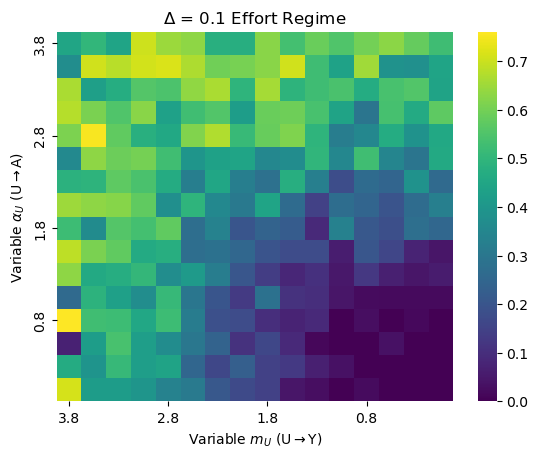

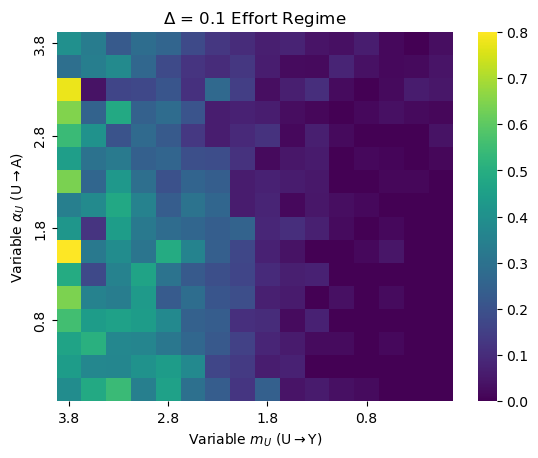

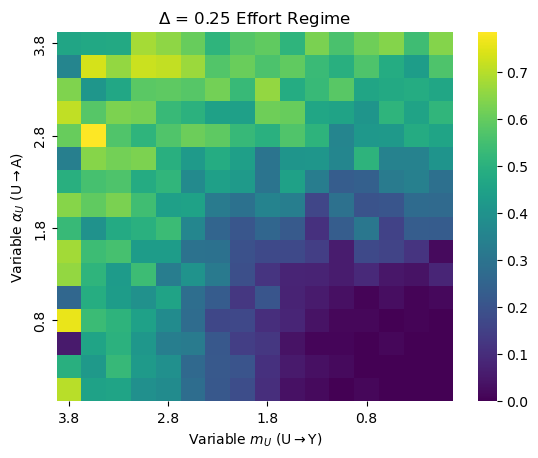

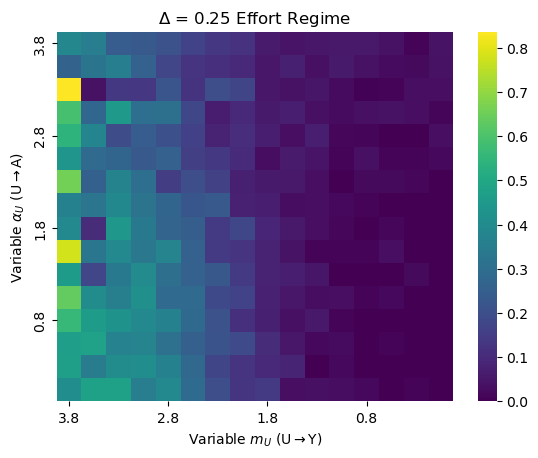

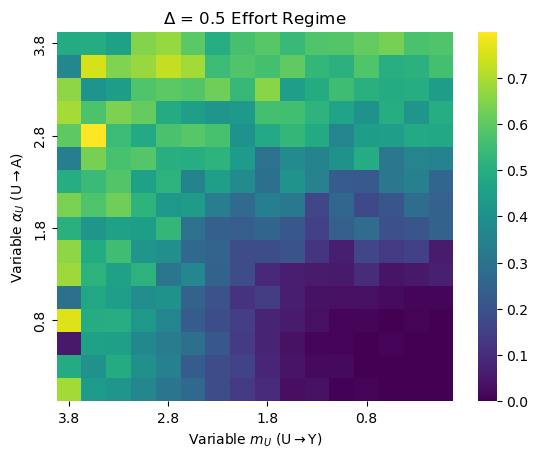

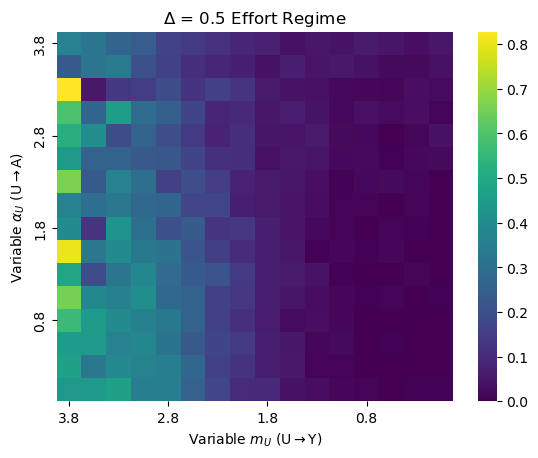

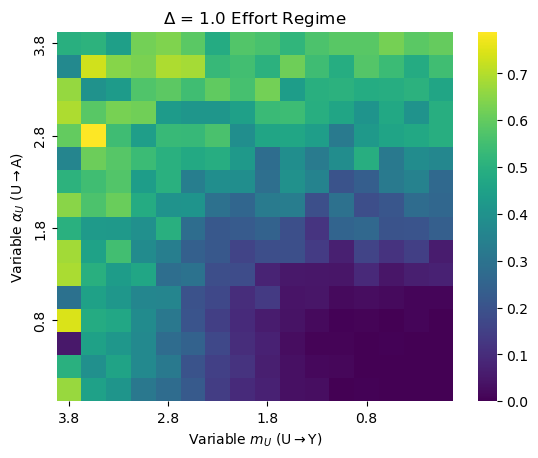

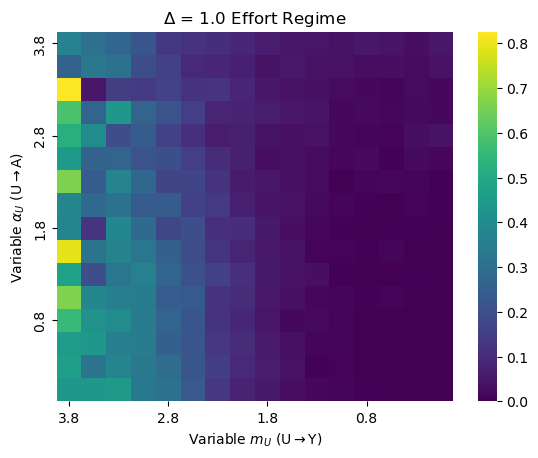

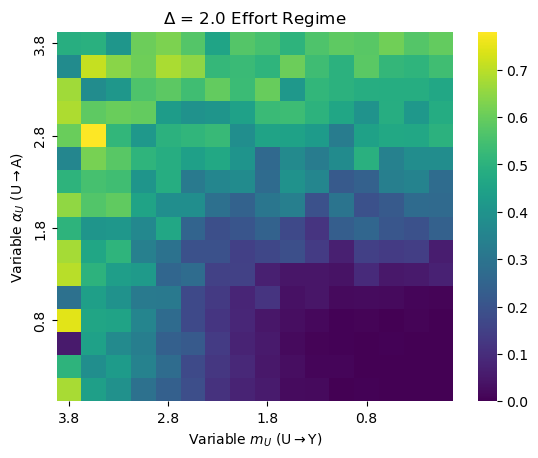

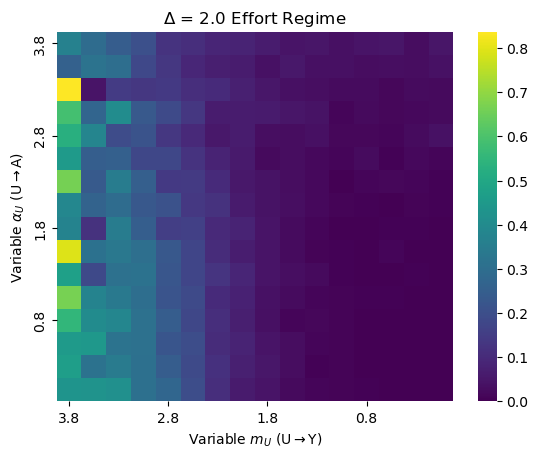

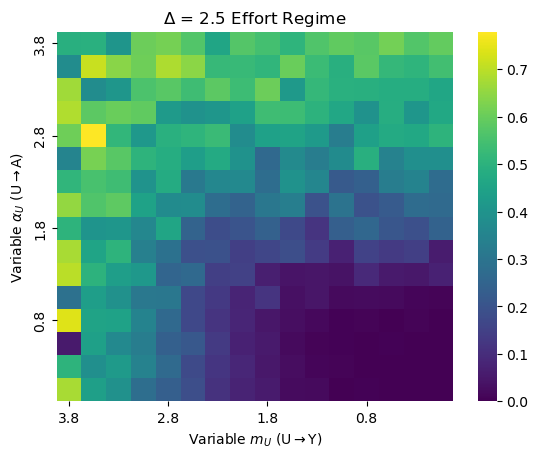

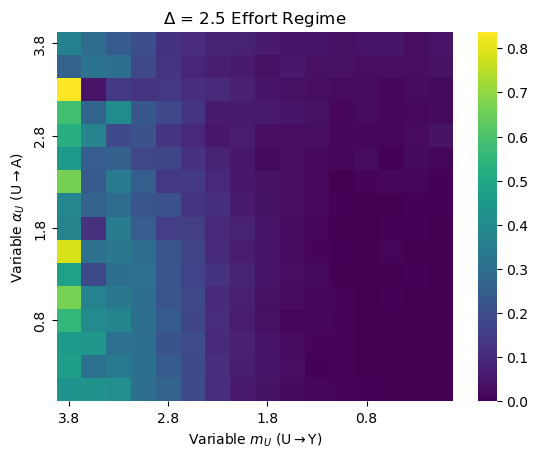

In [39]:
#DIFF IN IMPROVABILITY GRAPHS
ei_data_test["improve_data"] = np.array(ei_data_test["improve_data"])
for d, delta in enumerate(simulation_params["deltas"]):
  #print(ei_data_SY_test["ei_data"][d])
  #print(ei_data_SY_test["mask"][d])
  graph.heat_map_effort(sim_params = simulation_params, results = ei_data_test["improve_data"][d][:,:,0], 
                        type_graph = "Improvement_0", delta = delta, save=save_img)
  graph.heat_map_effort(sim_params = simulation_params, results = ei_data_test["improve_data"][d][:,:,1], 
                        type_graph = "Improvement_1", delta = delta, save=save_img)
  '''graph.heat_map_effort(ei_data_test["improve_data"][d][:,:,1], 
                              simulation_gaming["vars_0"], labels[simulation_gaming["str_vars"][0]], 
                              simulation_gaming["vars_1"], labels[simulation_gaming["str_vars"][1]], 
                              simulation_gaming["type_effort"][d], "Improvement_1", delta, save=save_img)'''

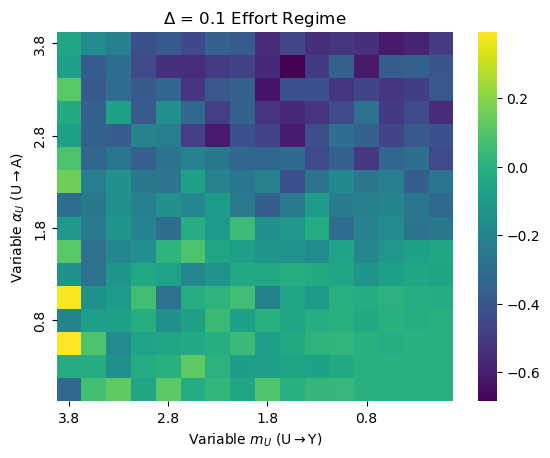

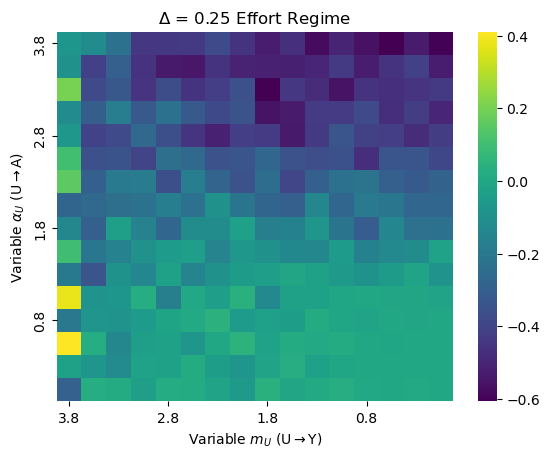

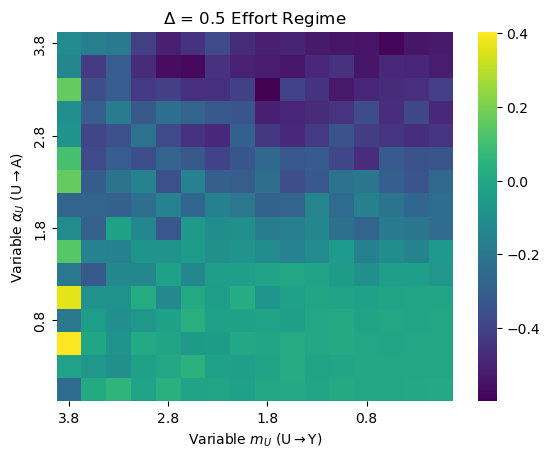

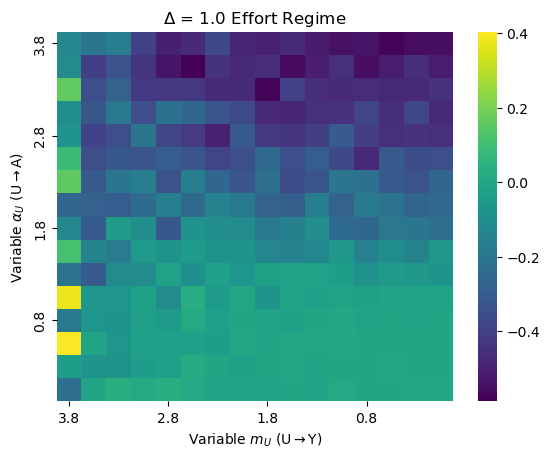

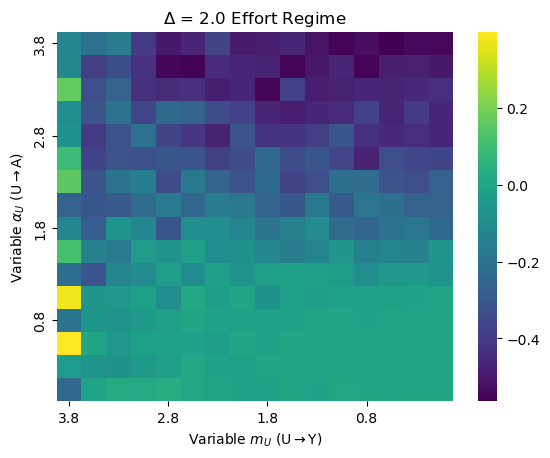

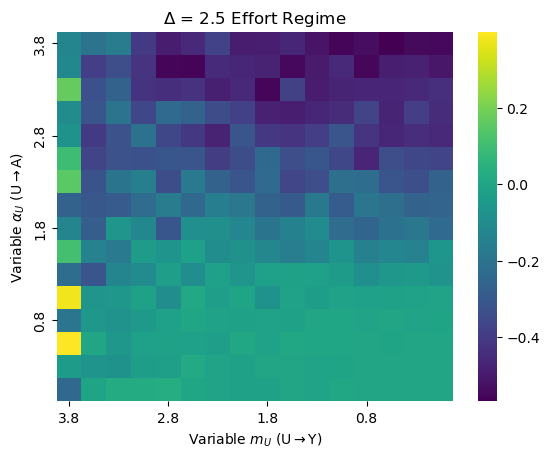

In [40]:
 #DIFF IN IMPROVABILITY GRAPHS
for d, delta in enumerate(simulation_params["deltas"]):
  #print(ei_data_SY_test["ei_data"][d])
  #print(ei_data_SY_test["mask"][d])
  graph.heat_map_effort(sim_params = simulation_params, 
                        results = ei_data_test["improve_data"][d][:,:,1] - ei_data_test["improve_data"][d][:,:,0], 
                        type_graph = "Improvement_diff", delta = delta, save=save_img)


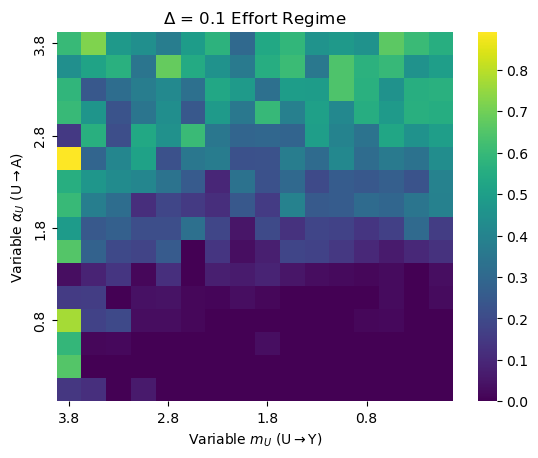

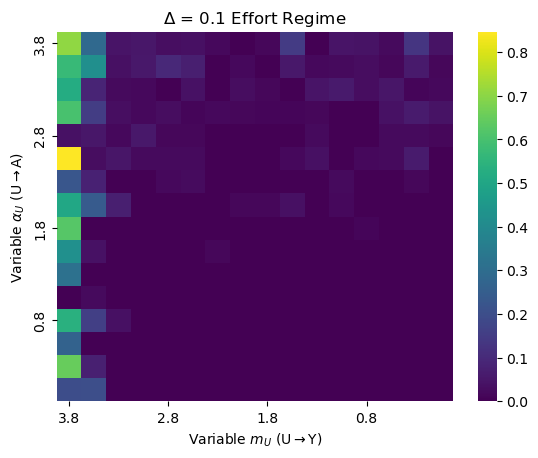

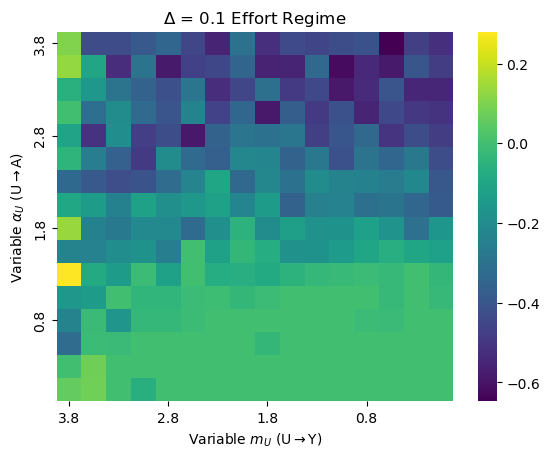

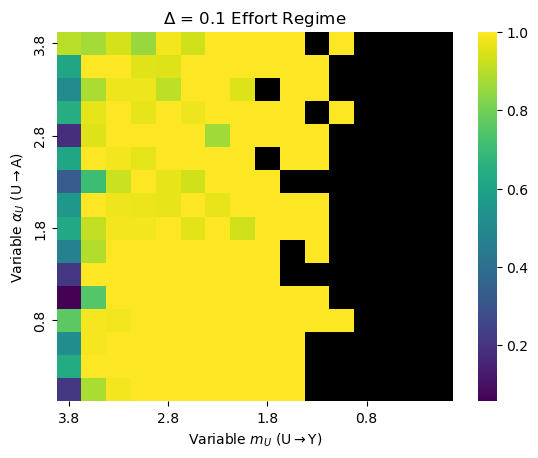

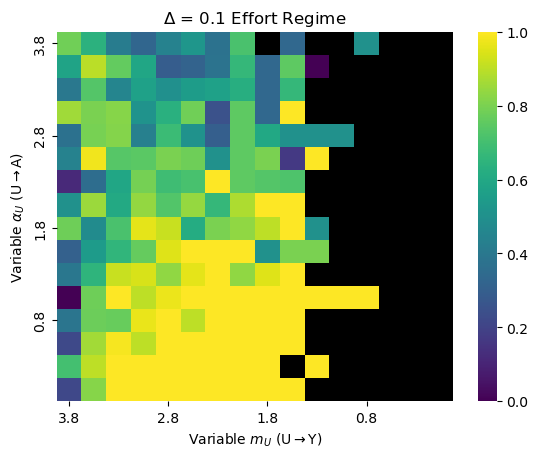

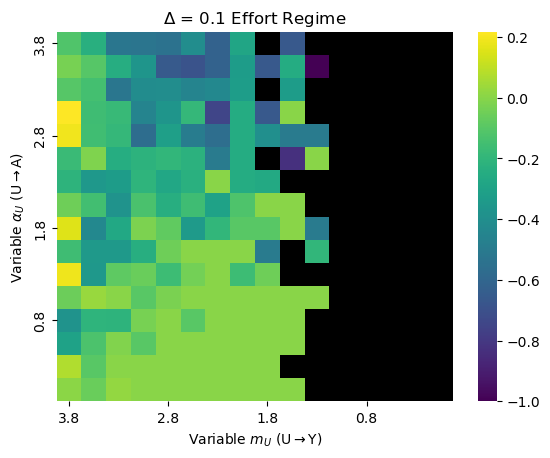

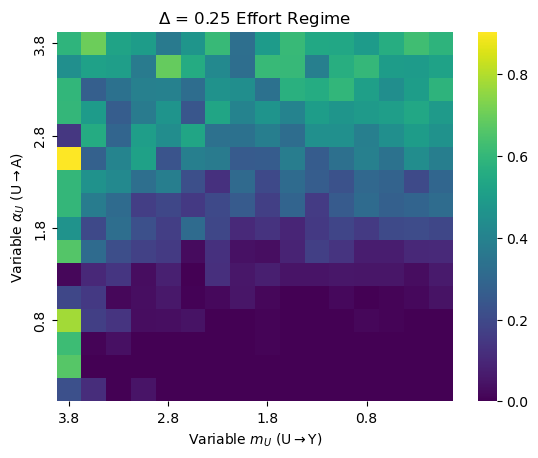

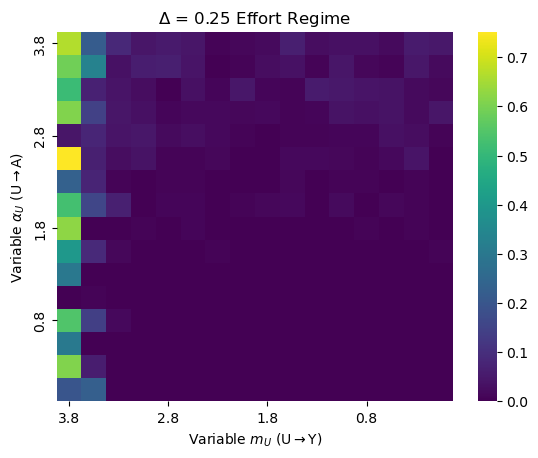

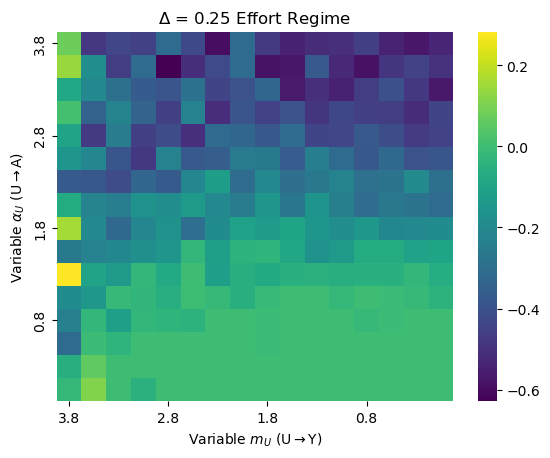

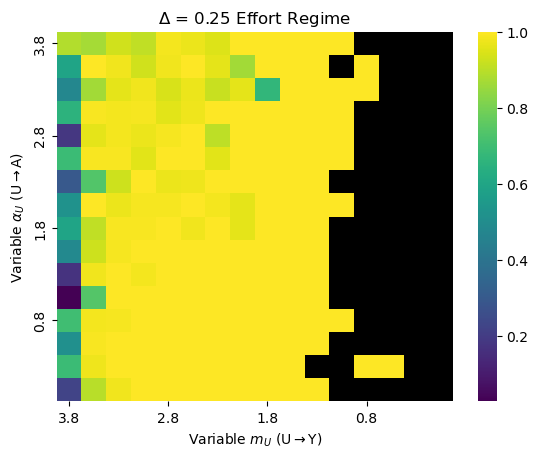

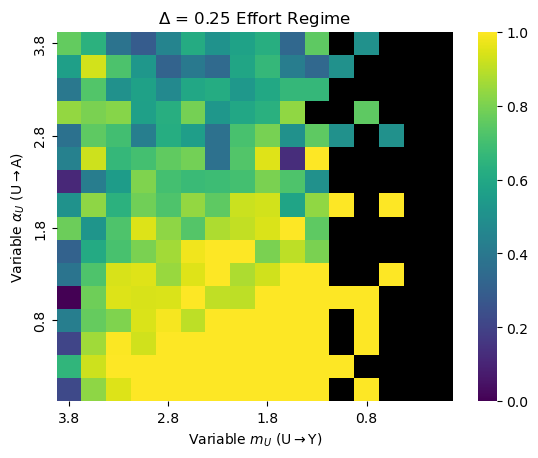

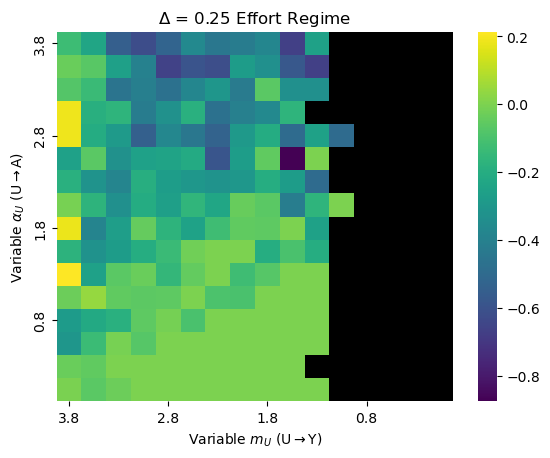

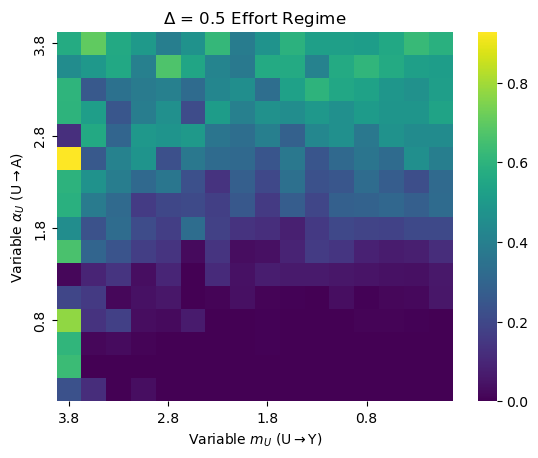

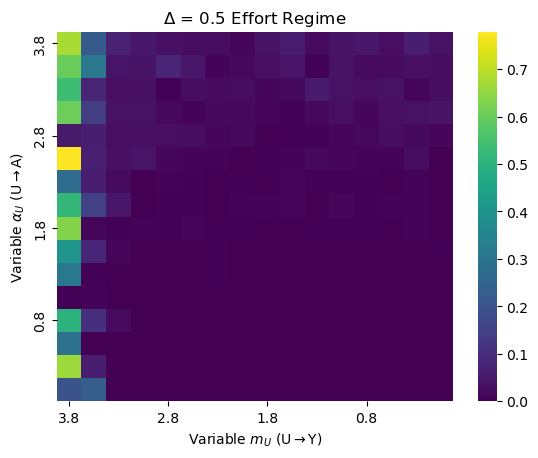

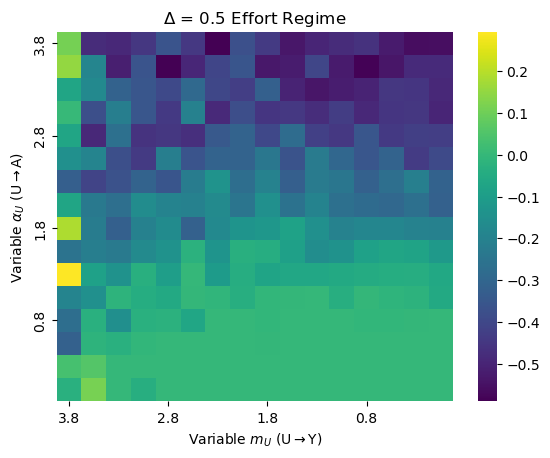

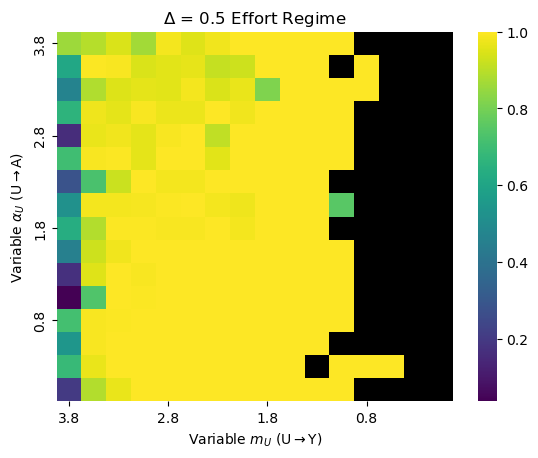

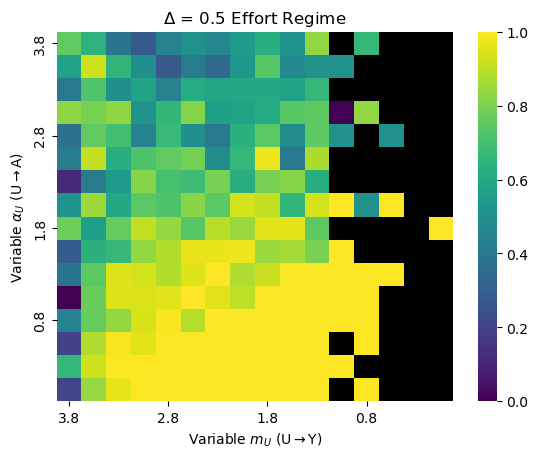

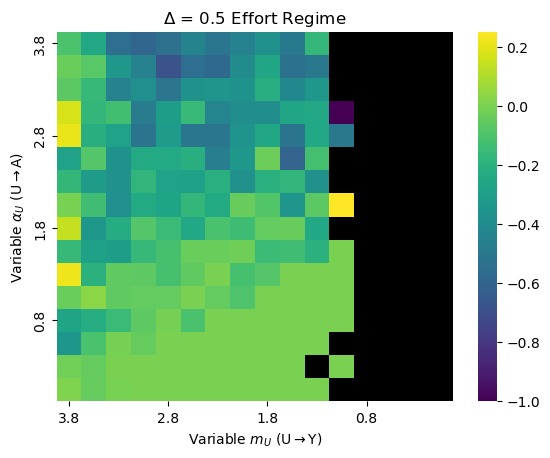

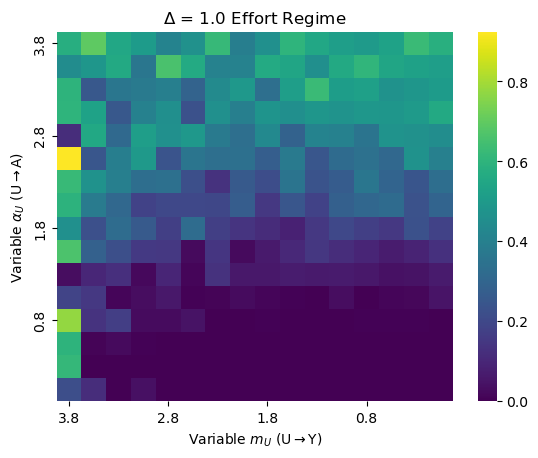

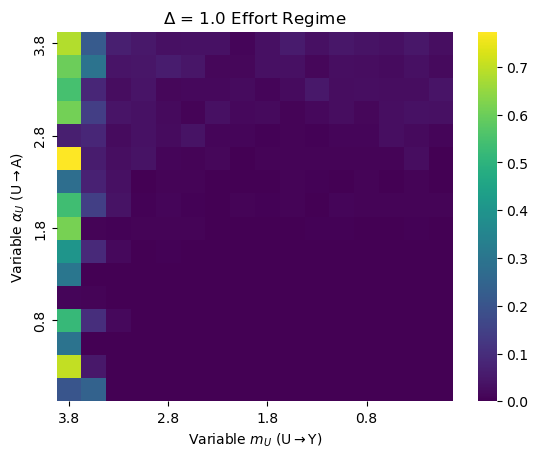

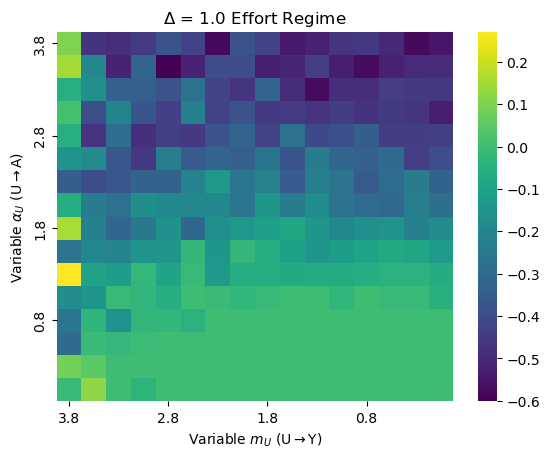

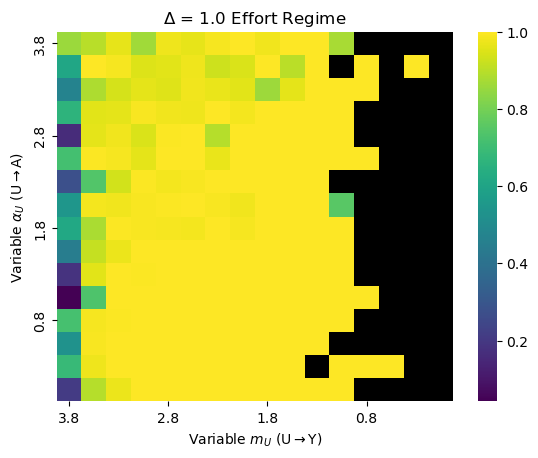

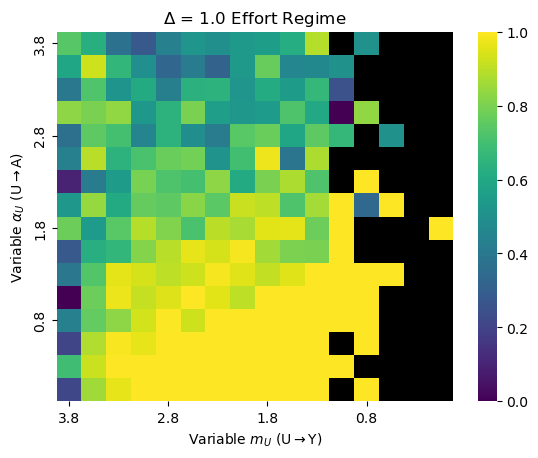

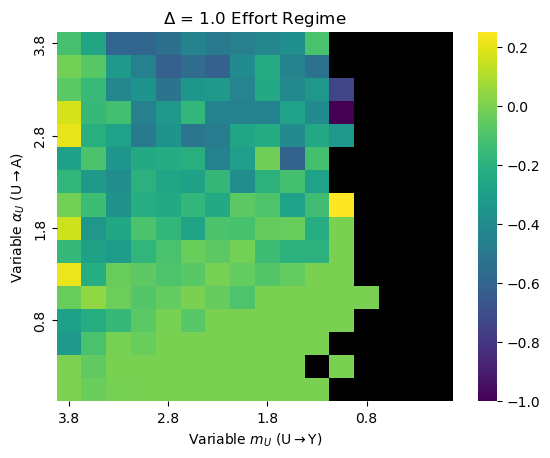

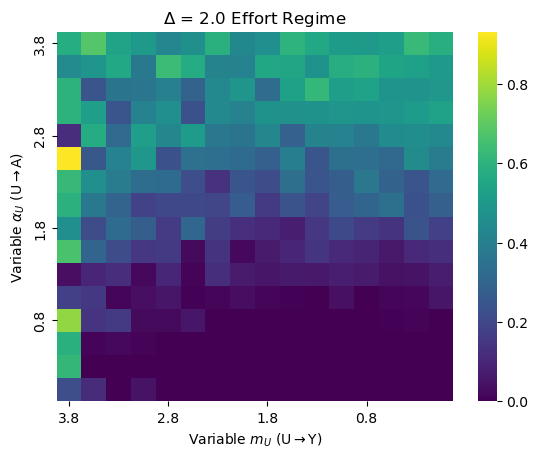

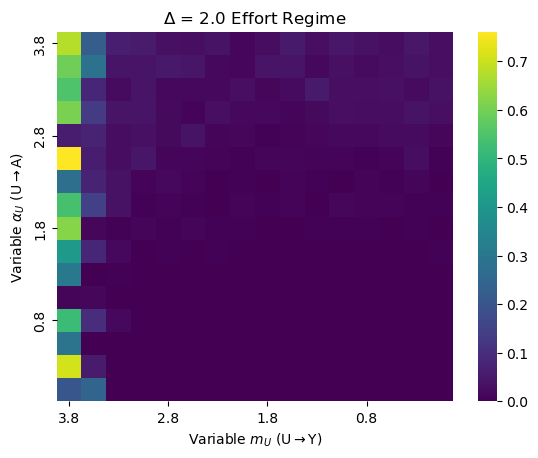

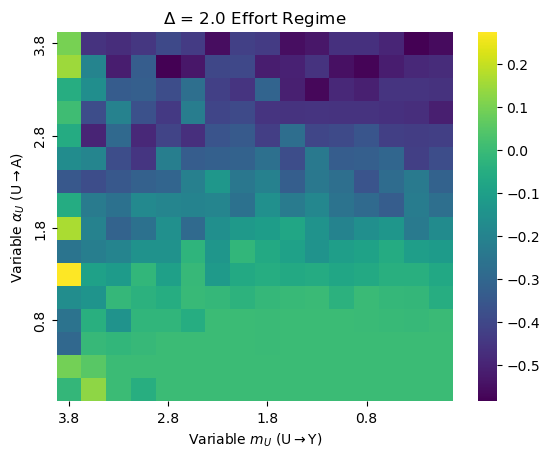

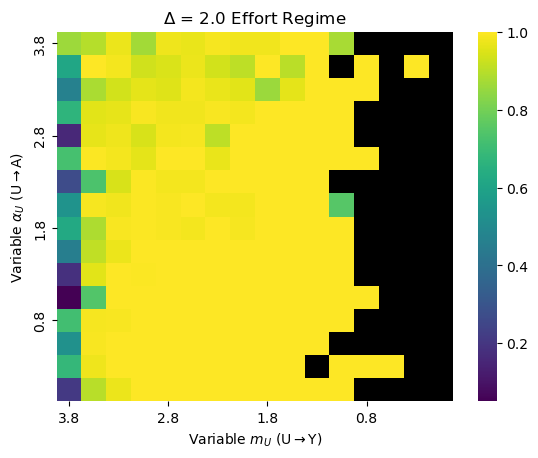

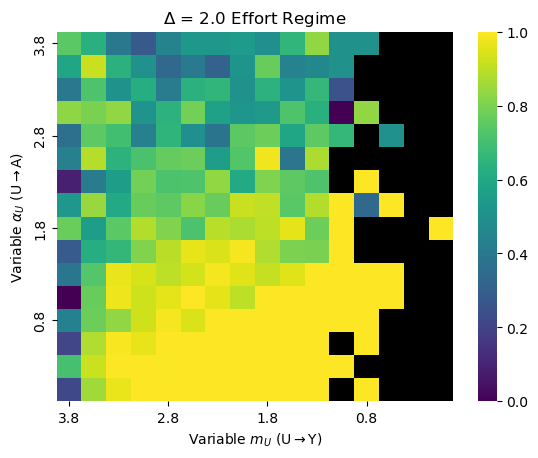

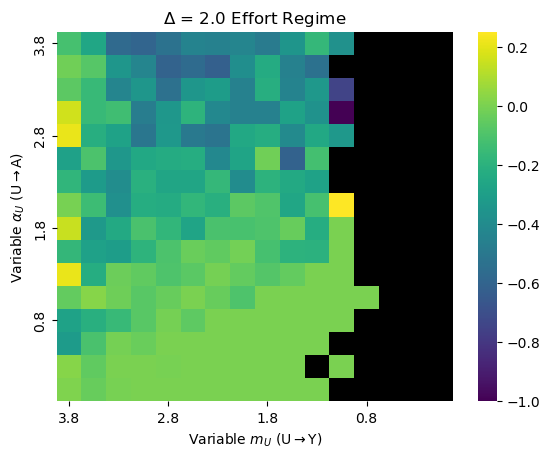

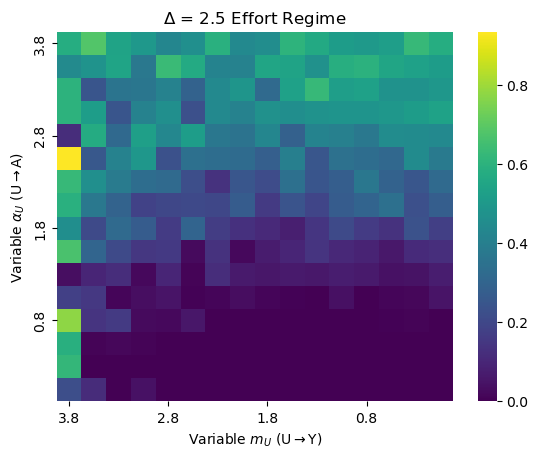

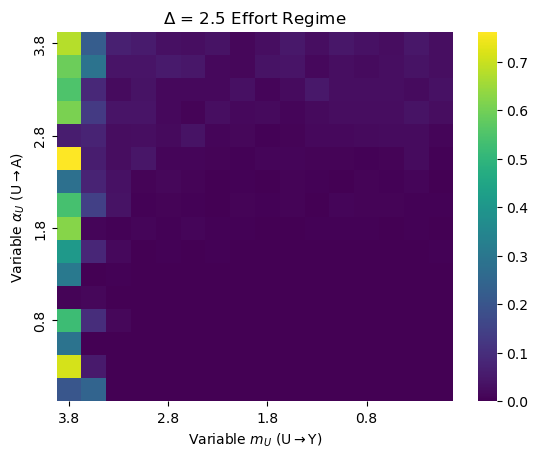

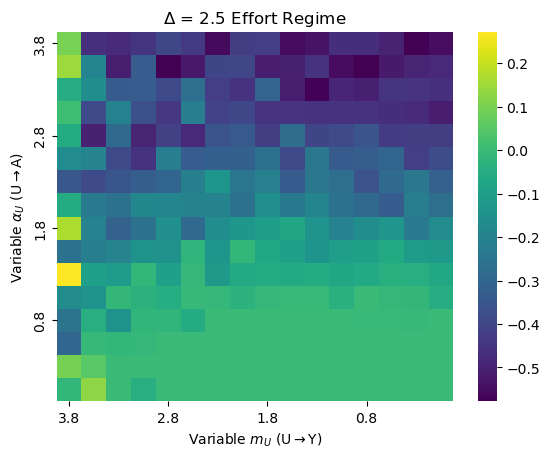

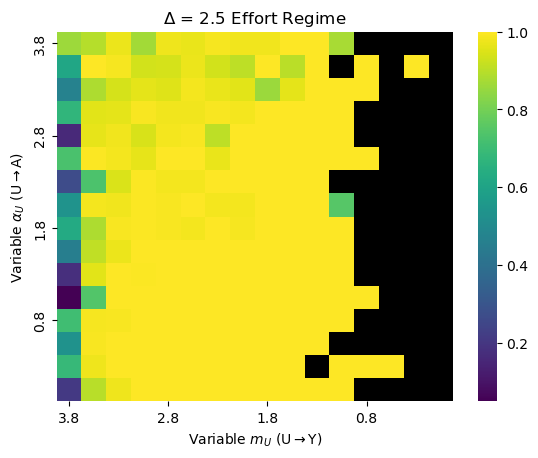

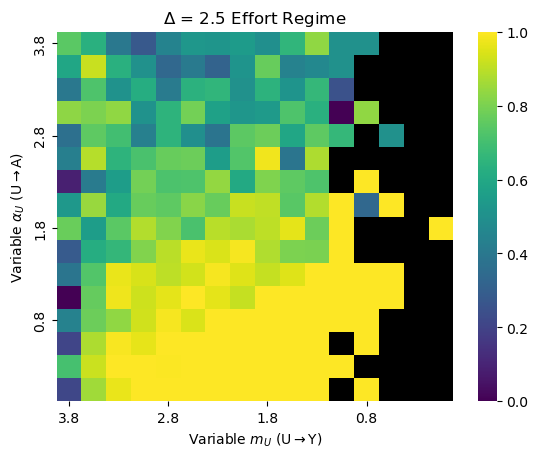

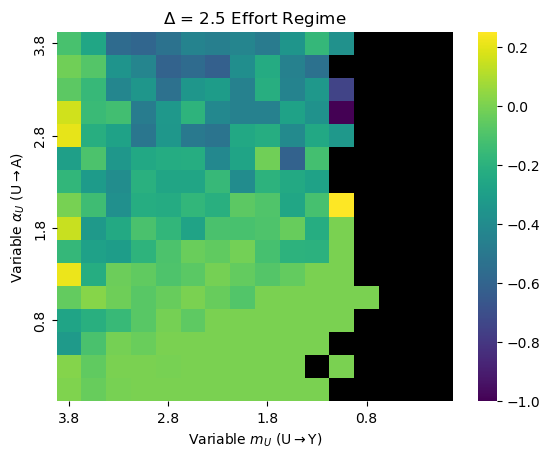

In [26]:
#DIFF IN IMPROVABILITY GRAPHS
ei_data_test["improve_data_U"] = np.array(ei_data_test["improve_data_U"])
for d, delta in enumerate(simulation_params["deltas"]):
  for u in range(2):
  #print(ei_data_SY_test["ei_data"][d])
  #print(ei_data_SY_test["mask"][d])
    graph.heat_map_effort(sim_params = simulation_params, 
                        results = ei_data_test["improve_data_U"][d][:,:,u,0], 
                        type_graph = "Improvement_u"+str(u)+"_s0", delta = delta, save=save_img)
    graph.heat_map_effort(sim_params = simulation_params, 
                        results = ei_data_test["improve_data_U"][d][:,:,u,1], 
                        type_graph = "Improvement_u"+str(u)+"_s1", delta = delta, save=save_img)
    graph.heat_map_effort(sim_params = simulation_params, 
                        results = ei_data_test["improve_data_U"][d][:,:,u,1] - ei_data_test["improve_data_U"][d][:,:,u,0], 
                        type_graph = "Improvement_u"+str(u)+"_diff", delta = delta, save=save_img)
    

In [34]:
ei_data_test["pred_feature_weights"] = np.array(ei_data_test["pred_feature_weights"])
#print(ei_data_test["pred_feature_weights"][0])

#print(np.argmin(ei_data_test["pred_feature_weights"][0]))
print(np.max(ei_data_test["pred_feature_weights"][0]))
temp_index = np.unravel_index(np.argmax(ei_data_test["pred_feature_weights"][0]), ei_data_test["pred_feature_weights"][0].shape)
print(ei_data_test["pred_feature_weights"][1][temp_index])

print(ei_data_test["pred_feature_weights"].shape)

graph.heat_map_effort(sim_params = simulation_params, 
                        results = ei_data_test["pred_feature_weights"][0], 
                        type_graph = "Pred_weights_A", delta = None, save=save_img)

graph.heat_map_effort(sim_params = simulation_params, 
                        results = ei_data_test["pred_feature_weights"][1], 
                        type_graph = "Pred_weights_C", delta = None, save=save_img)

graph.heat_map_effort(sim_params = simulation_params, 
                        results = ei_data_test["pred_feature_weights"][2], 
                        type_graph = "Pred_weights_U", delta = None, save=save_img)


1.11341437835776
1.11341437835776
(2, 16, 16, 2)


ValueError: Must pass 2-d input. shape=(16, 16, 2)

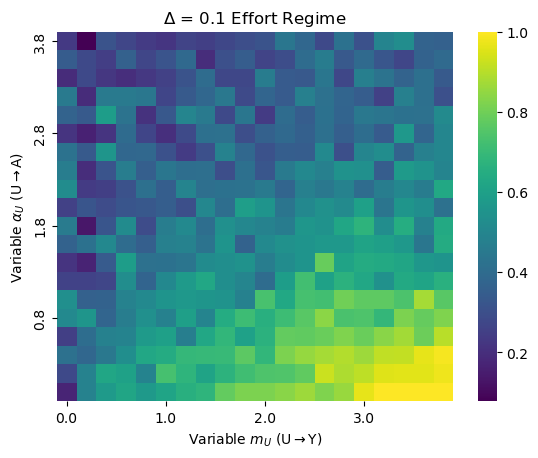

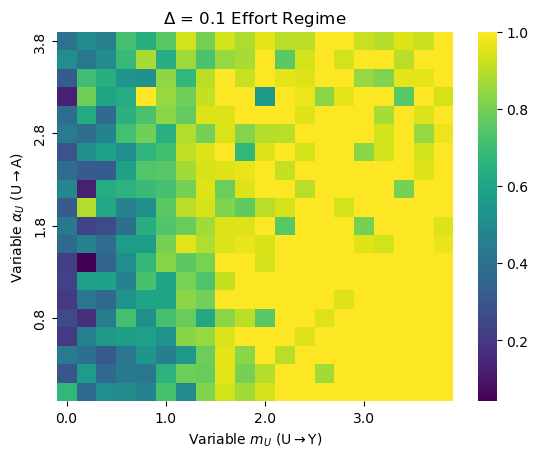

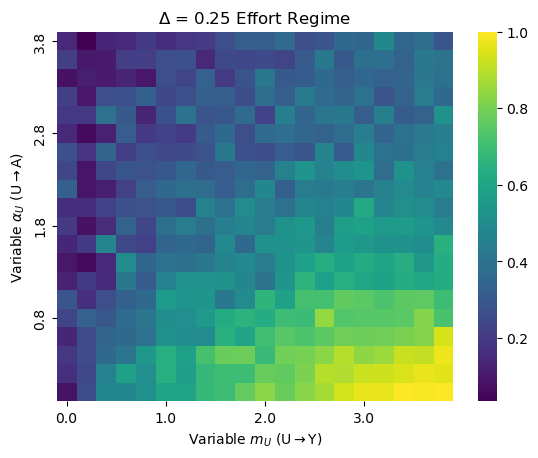

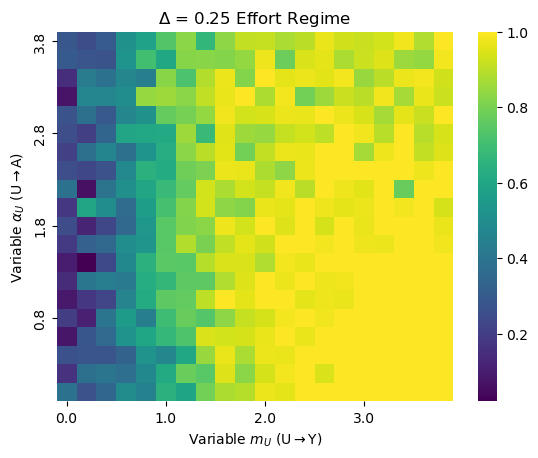

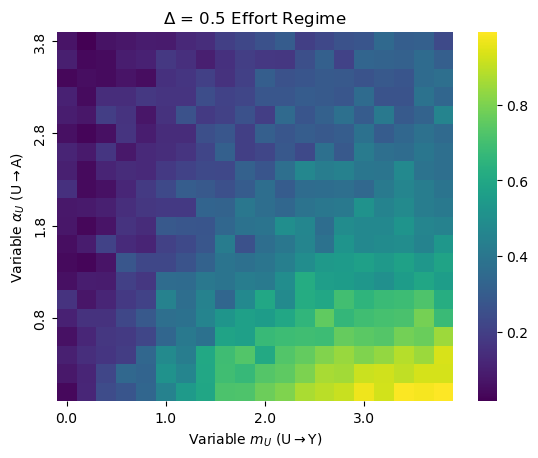

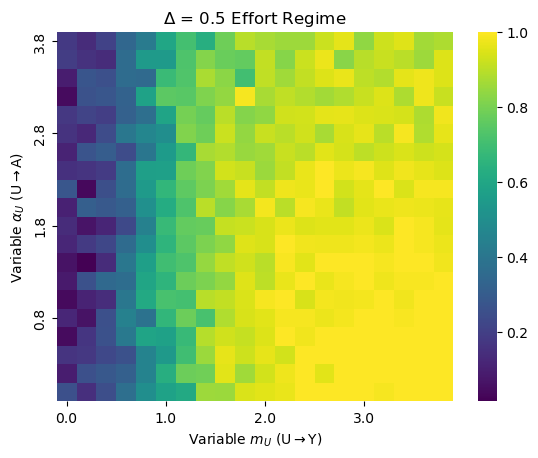

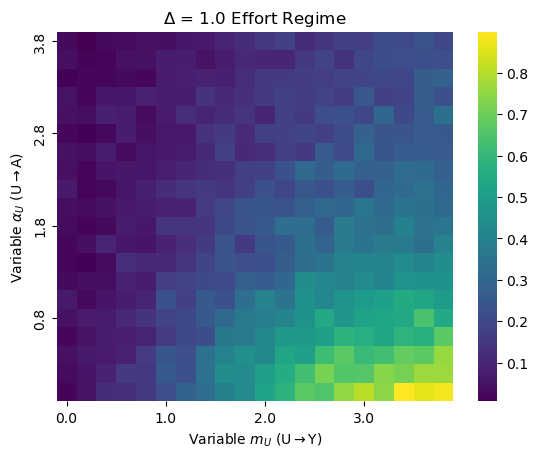

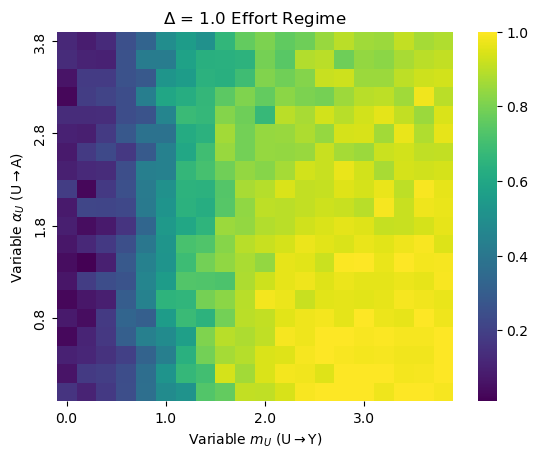

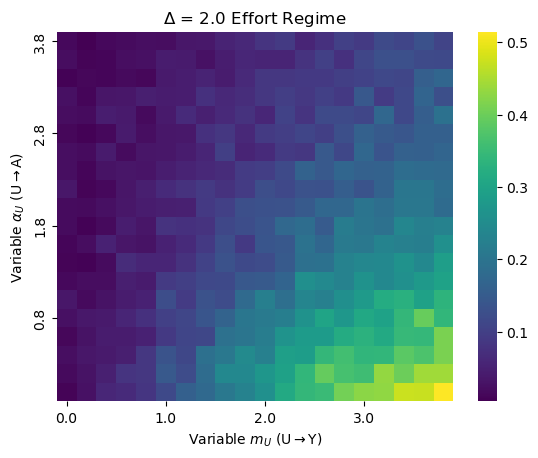

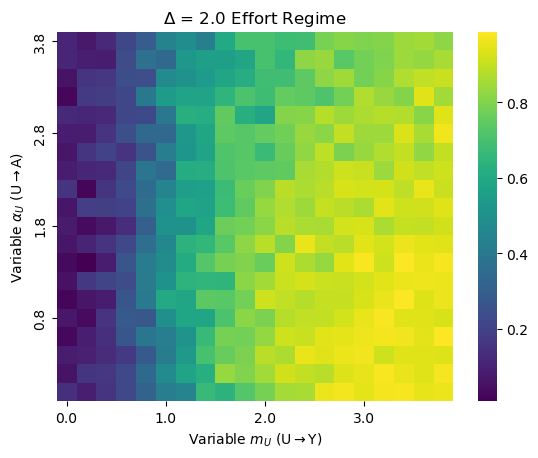

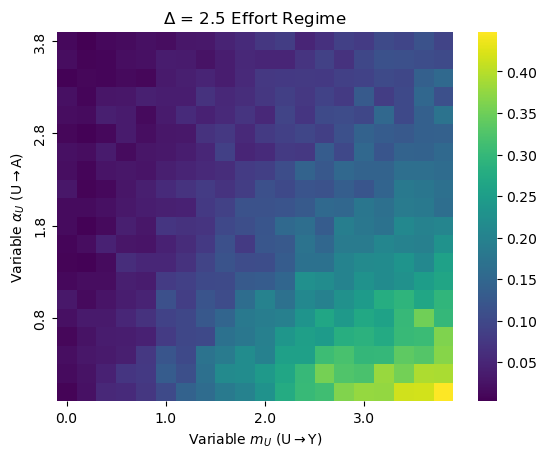

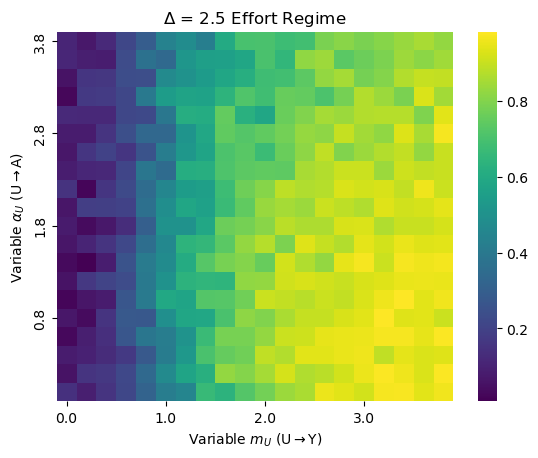

In [29]:
type_d="pred_"
ei_data_test[type_d+"improvable_labels"] = np.array(ei_data_test[type_d+"improvable_labels"])
#DIFF IN IMPROVABILITY GRAPHS
for d, delta in enumerate(simulation_gaming["deltas"]):
  #print(ei_data_SY_test["ei_data"][d])
  #print(ei_data_SY_test["mask"][d])
  graph.heat_map_effort(sim_params = simulation_params, 
                        results = ei_data_test[type_d+"improvable_labels"][d][:,:,0], 
                        type_graph = type_d+"Improvable_labels_0", delta = None, save=save_img)

  graph.heat_map_effort(sim_params = simulation_params, 
                        results = ei_data_test[type_d+"improvable_labels"][d][:,:,1], 
                        type_graph = type_d+"Improvable_labels_1", delta = None, save=save_img)
  

DELTA =  0.1
minority group


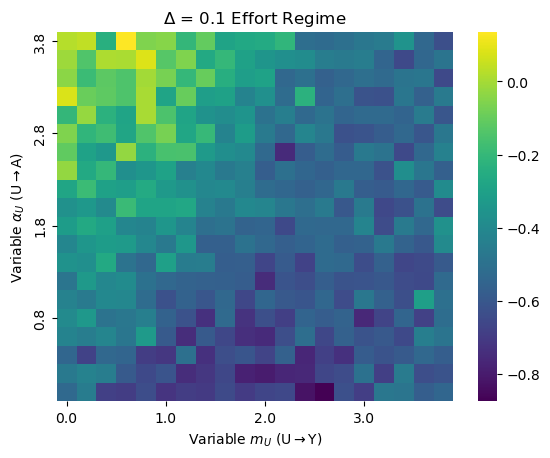

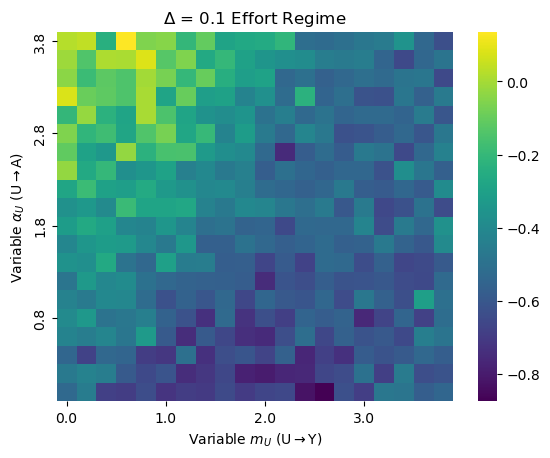

majority group


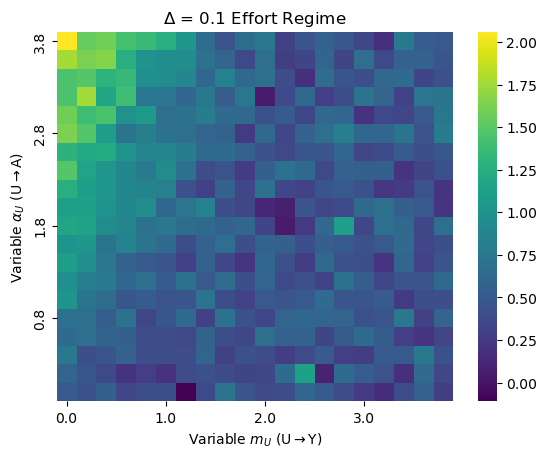

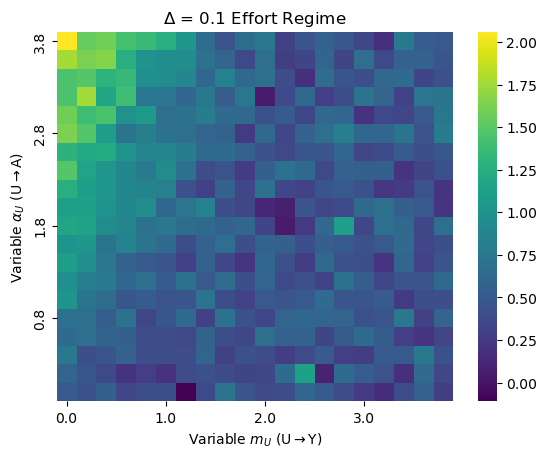

diff


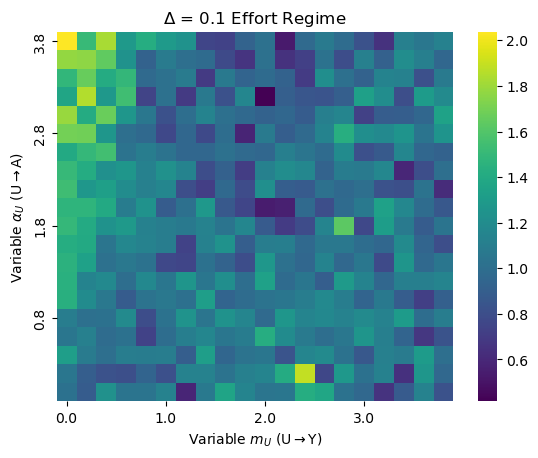

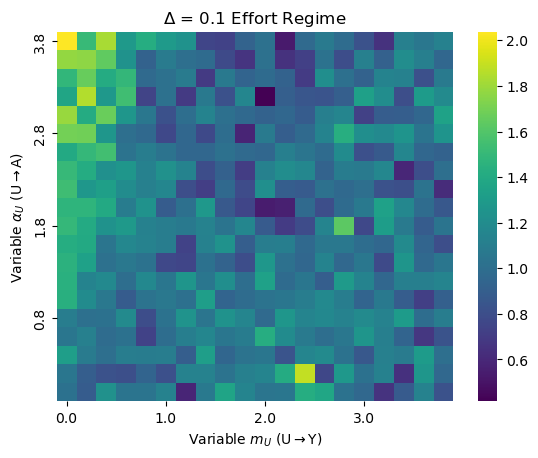

DELTA =  0.25
minority group


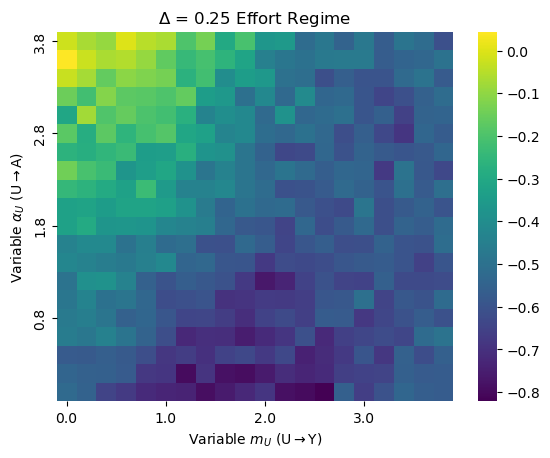

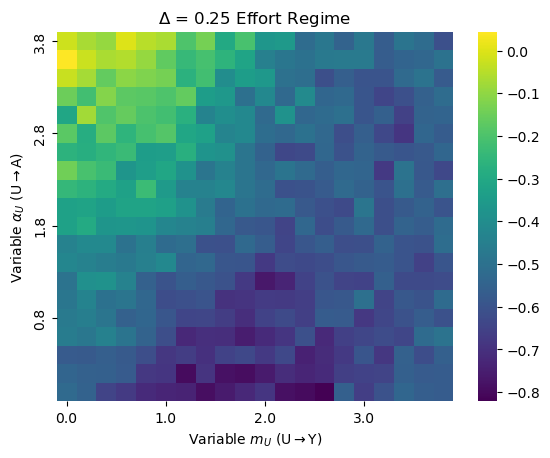

majority group


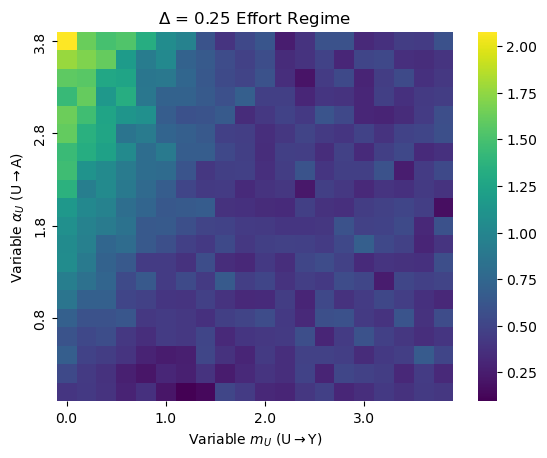

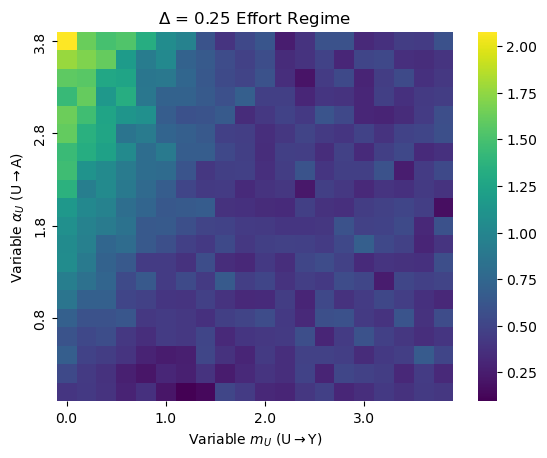

diff


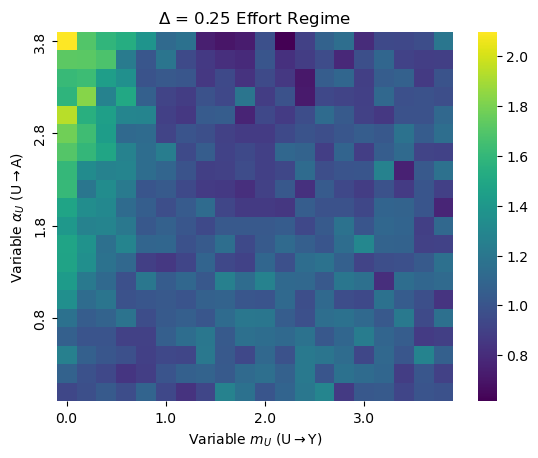

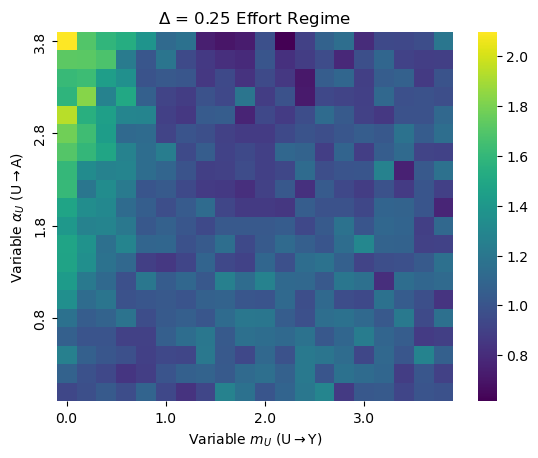

DELTA =  0.5
minority group


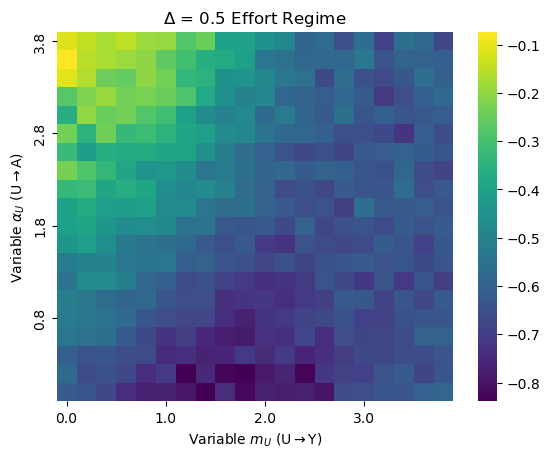

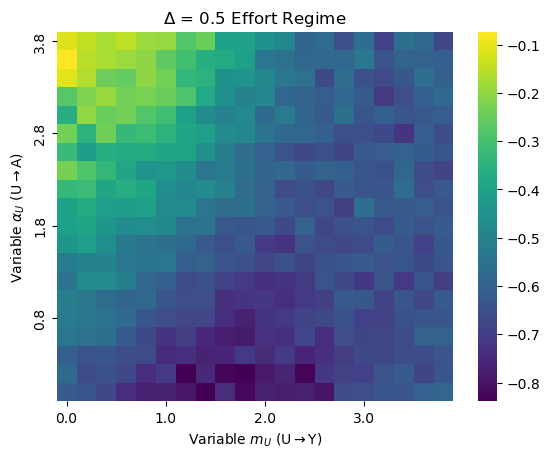

majority group


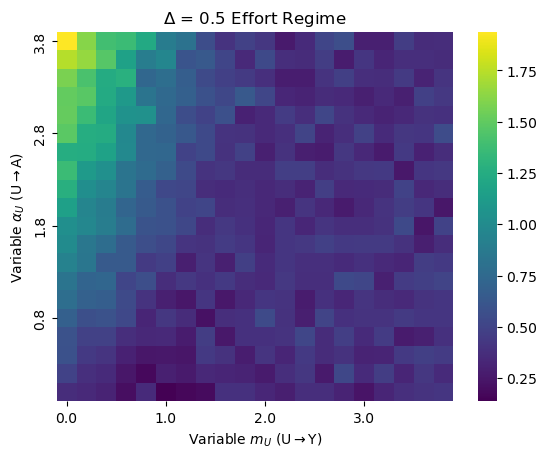

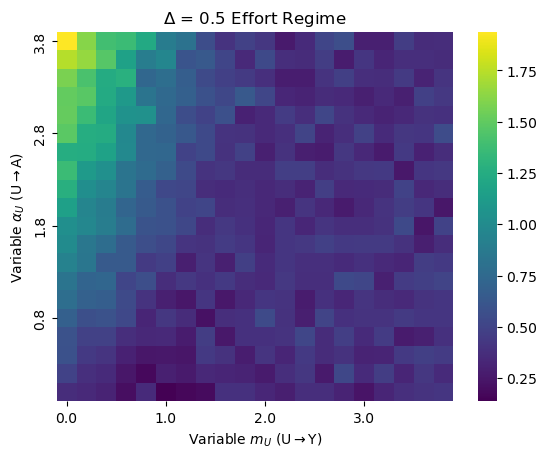

diff


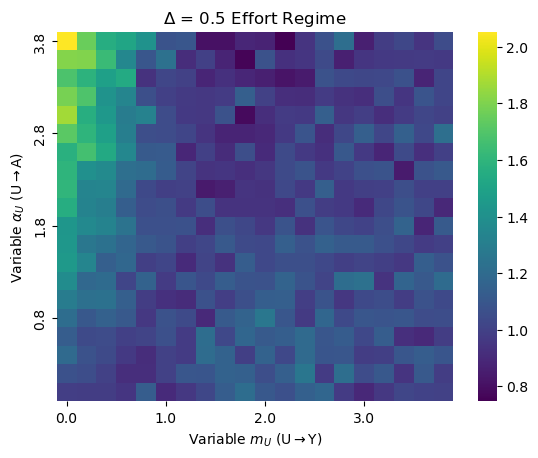

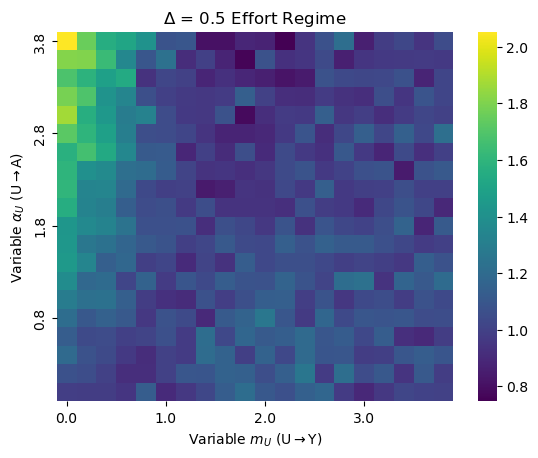

DELTA =  1.0
minority group


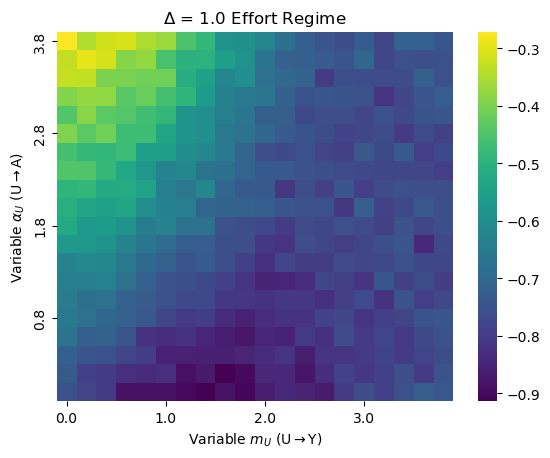

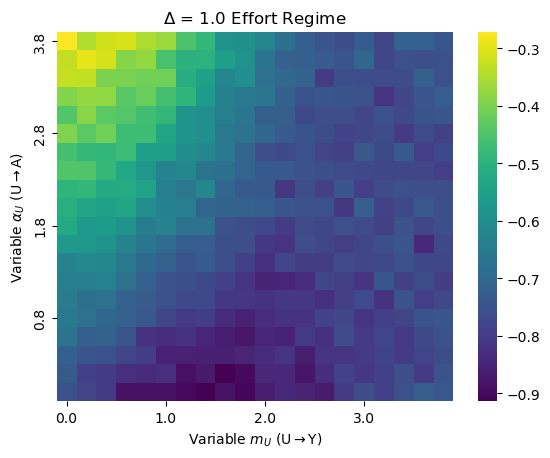

majority group


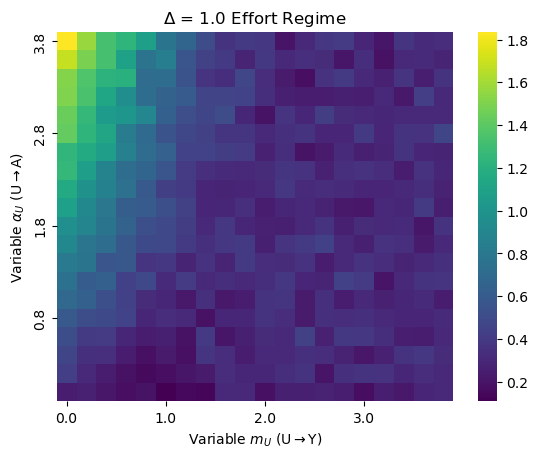

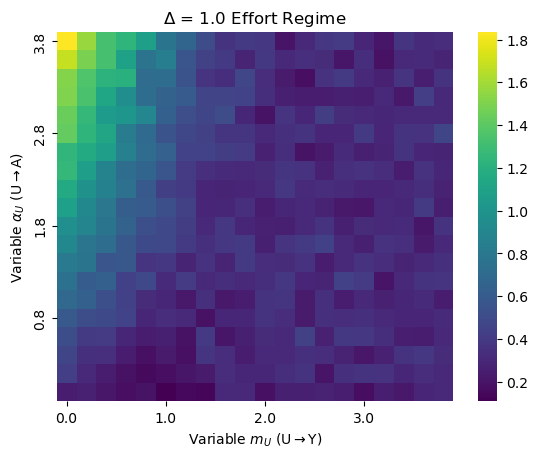

diff


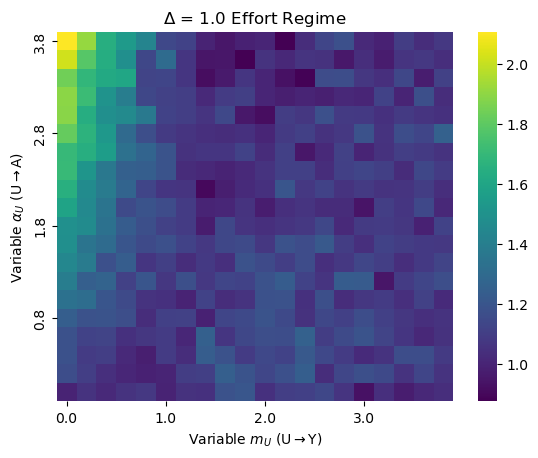

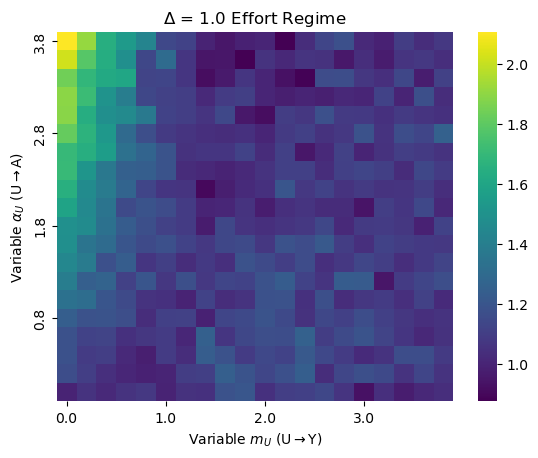

DELTA =  2.0
minority group


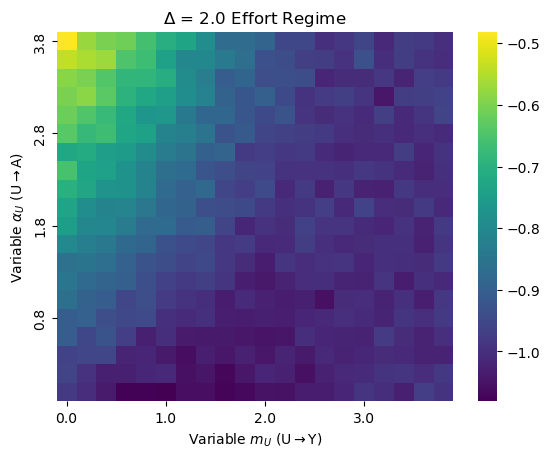

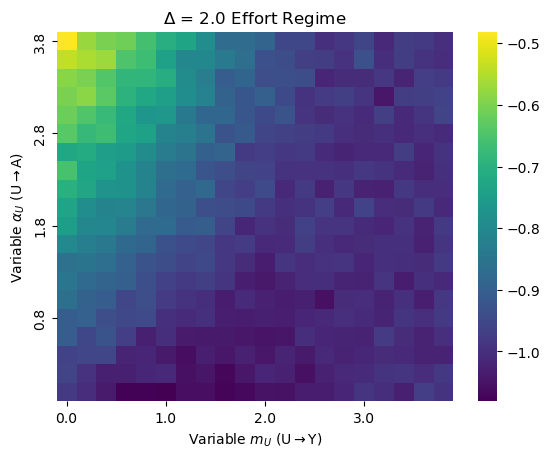

majority group


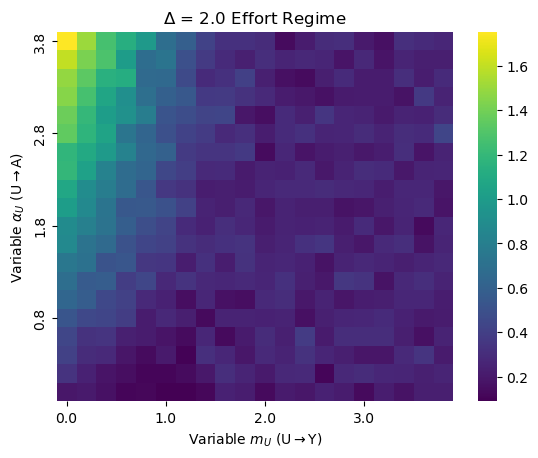

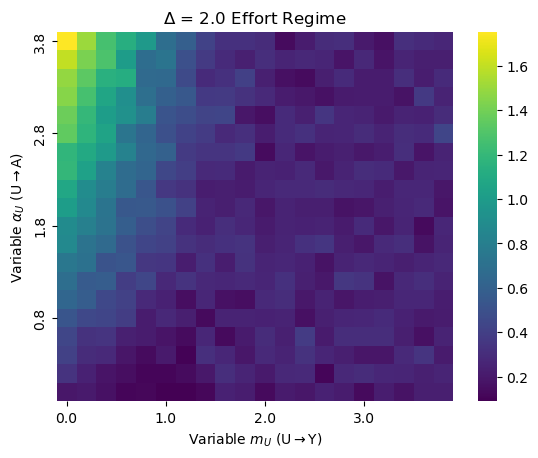

diff


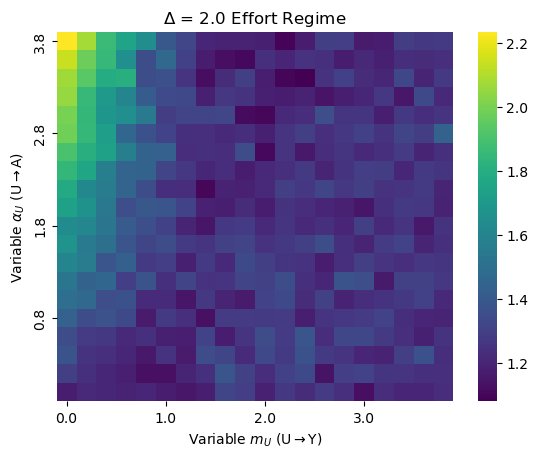

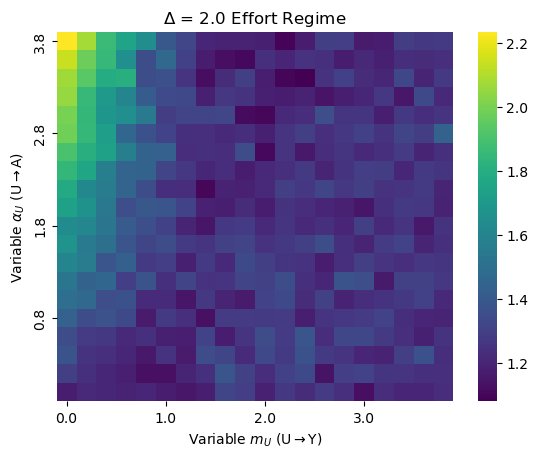

DELTA =  2.5
minority group


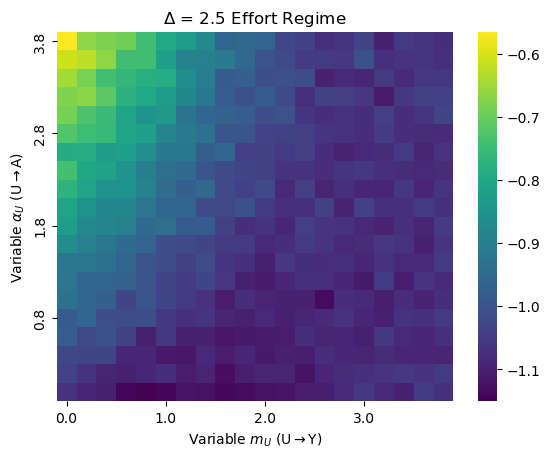

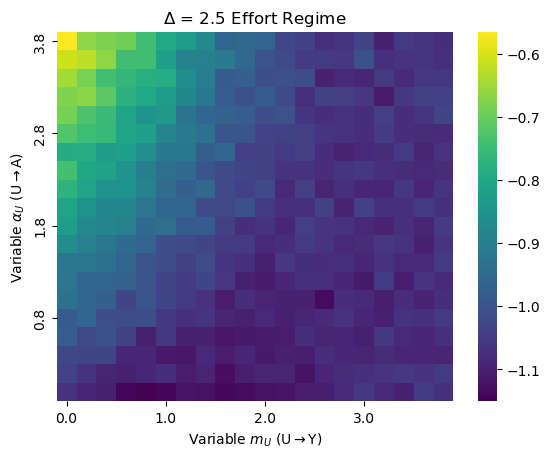

majority group


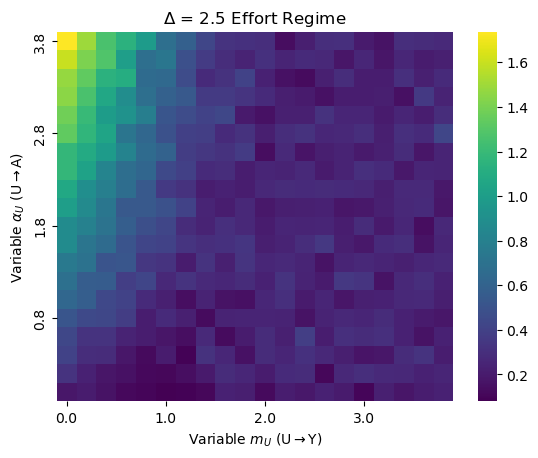

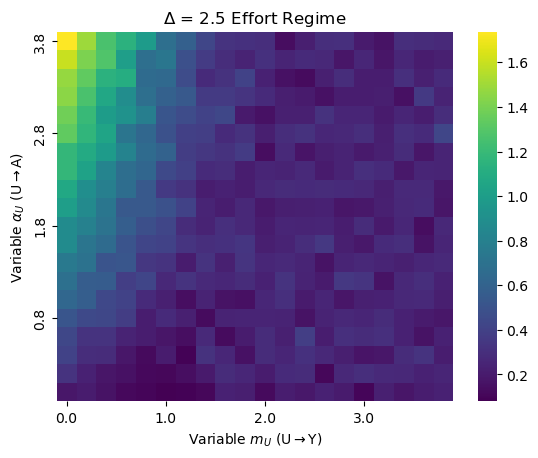

diff


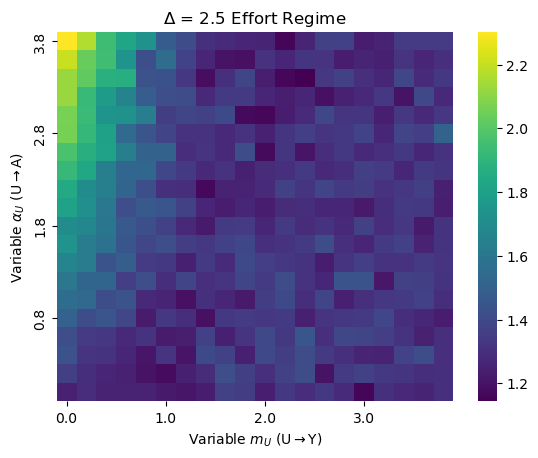

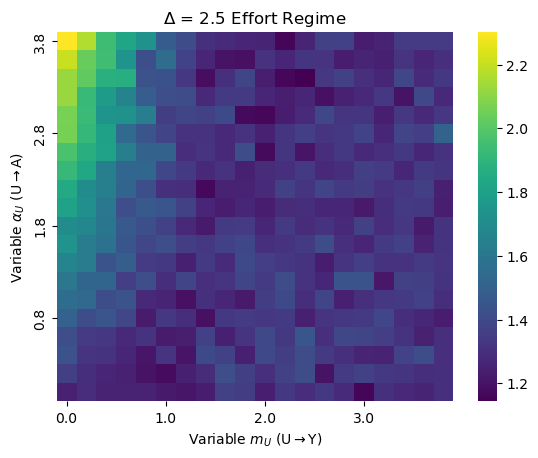

In [30]:
'''type_d="pred_"
#DIFF IN IMPROVABILITY GRAPHS
for d, delta in enumerate(simulation_gaming["deltas"]):
  print("DELTA = ", delta)
  #print(ei_data_SY_test["ei_data"][d])
  #print(ei_data_SY_test["mask"][d])
  print("minority group")
  graph.all_improve_heat_map_effort(ei_data_test[type_d+"improvable_features"][0,d,:,:,0], 
                              simulation_gaming["vars_0"], labels[simulation_gaming["str_vars"][0]], 
                              simulation_gaming["vars_1"], labels[simulation_gaming["str_vars"][1]],  
                              simulation_gaming["type_effort"][d], "Improvable_feature_A0", delta, save=False)
  graph.all_improve_heat_map_effort(ei_data_test[type_d+"improvable_features"][1,d,:,:,0], 
                              simulation_gaming["vars_0"], labels[simulation_gaming["str_vars"][0]], 
                              simulation_gaming["vars_1"], labels[simulation_gaming["str_vars"][1]], 
                              simulation_gaming["type_effort"][d], "Improvable_feature_C0", delta, save=False)
  print("majority group")
  graph.all_improve_heat_map_effort(ei_data_test[type_d+"improvable_features"][0,d,:,:,1], 
                              simulation_gaming["vars_0"], labels[simulation_gaming["str_vars"][0]], 
                              simulation_gaming["vars_1"], labels[simulation_gaming["str_vars"][1]], 
                              simulation_gaming["type_effort"][d], "Improvable_feature_A1", delta, save=False)
  graph.all_improve_heat_map_effort(ei_data_test[type_d+"improvable_features"][1,d,:,:,1], 
                              simulation_gaming["vars_0"], labels[simulation_gaming["str_vars"][0]], 
                              simulation_gaming["vars_1"], labels[simulation_gaming["str_vars"][1]], 
                              simulation_gaming["type_effort"][d], "Improvable_feature_C1", delta, save=False)
  print("diff")
  graph.all_improve_heat_map_effort(ei_data_test[type_d+"improvable_features"][0,d,:,:,1] - ei_data_test[type_d+"improvable_features"][0,d,:,:,0], 
                              simulation_gaming["vars_0"], labels[simulation_gaming["str_vars"][0]], 
                              simulation_gaming["vars_1"], labels[simulation_gaming["str_vars"][1]], 
                              simulation_gaming["type_effort"][d], "Improvable_feature_A_diff", delta, save=False)
  graph.all_improve_heat_map_effort(ei_data_test[type_d+"improvable_features"][1,d,:,:,1] - ei_data_test[type_d+"improvable_features"][1,d,:,:,0], 
                              simulation_gaming["vars_0"], labels[simulation_gaming["str_vars"][0]], 
                              simulation_gaming["vars_1"], labels[simulation_gaming["str_vars"][1]], 
                              simulation_gaming["type_effort"][d], "Improvable_feature_C_diff", delta, save=False)
'''

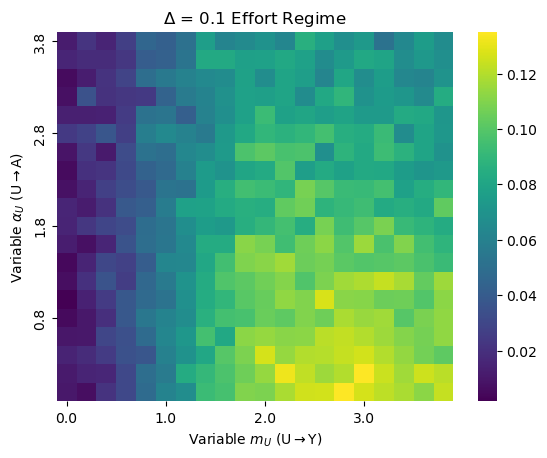

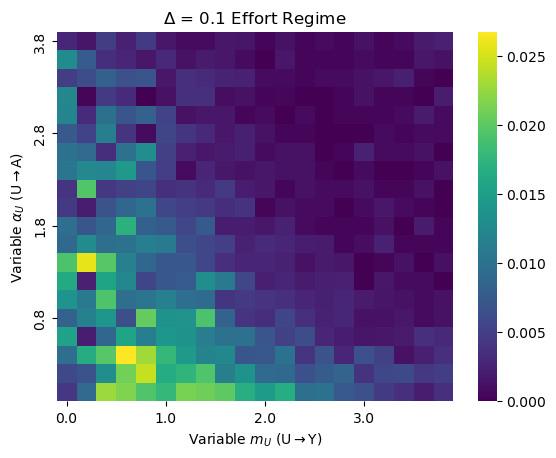

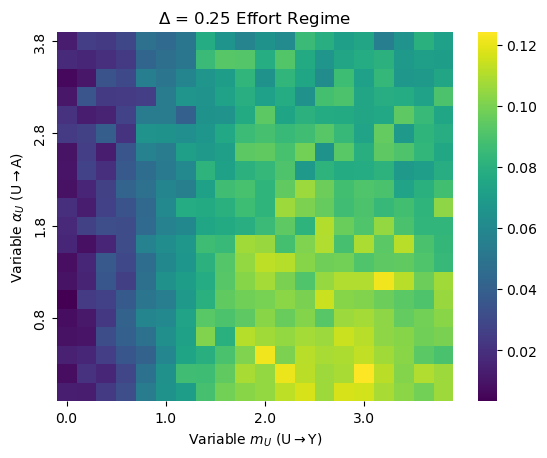

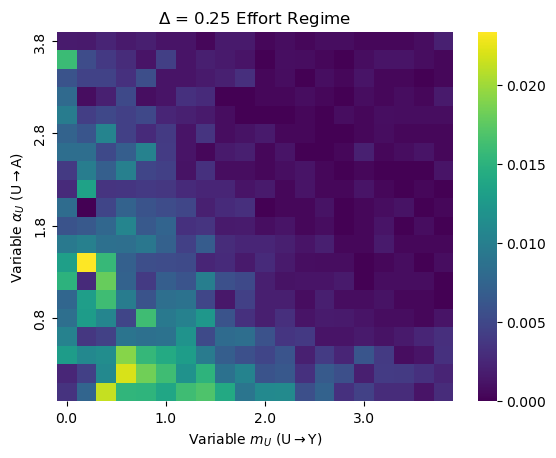

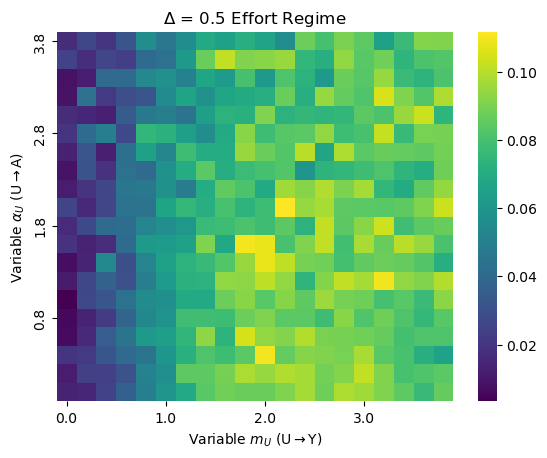

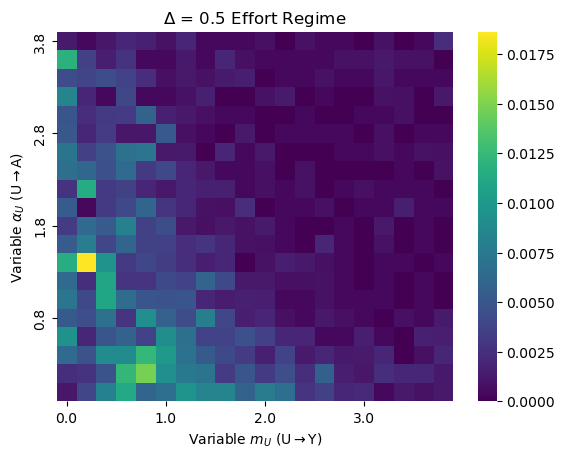

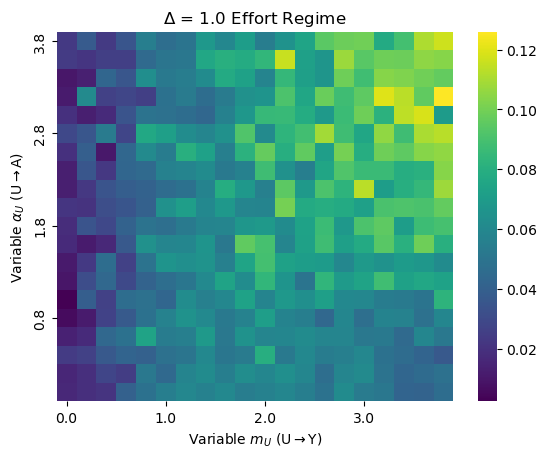

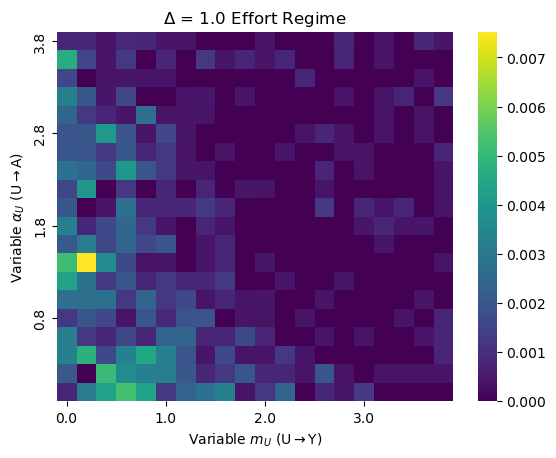

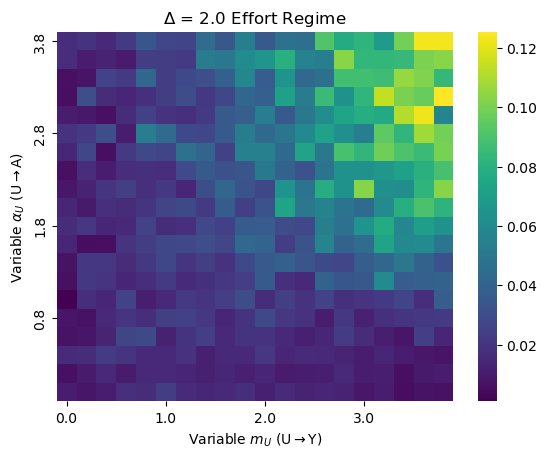

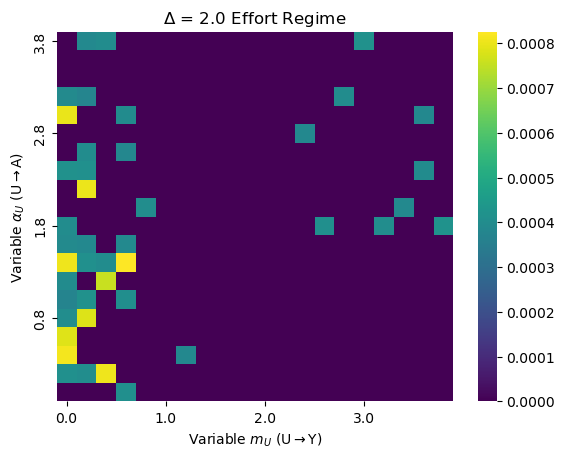

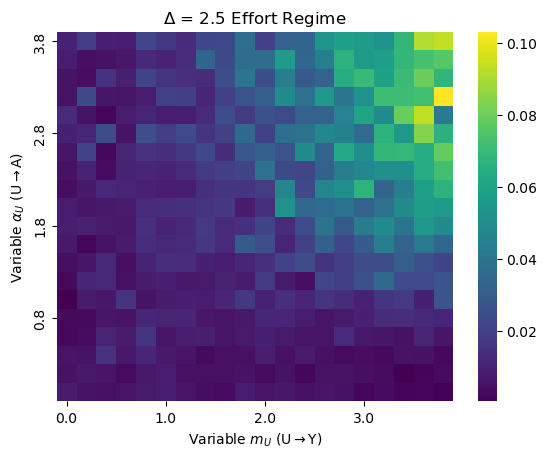

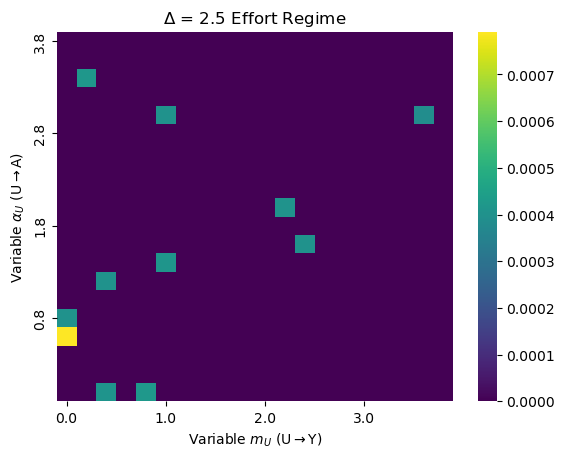

In [31]:
ei_data_test["pred_delta_too_high"] = np.array(ei_data_test["pred_delta_too_high"])
for d, delta in enumerate(simulation_gaming["deltas"]):
  #print(ei_data_SY_test["ei_data"][d])
  #print(ei_data_SY_test["mask"][d])
  graph.heat_map_effort(sim_params = simulation_params, 
                        results = ei_data_test["pred_delta_too_high"][d][:,:,0], 
                        type_graph = "pred_delta_high_0", delta = None, save=save_img)
  graph.heat_map_effort(sim_params = simulation_params, 
                        results = ei_data_test["pred_delta_too_high"][d][:,:,1], 
                        type_graph = "pred_delta_high_1", delta = None, save=save_img)


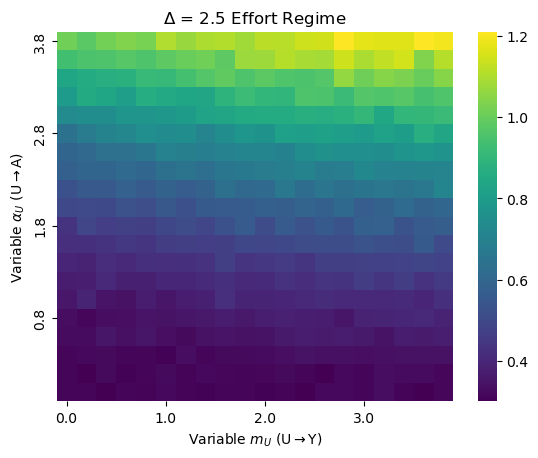

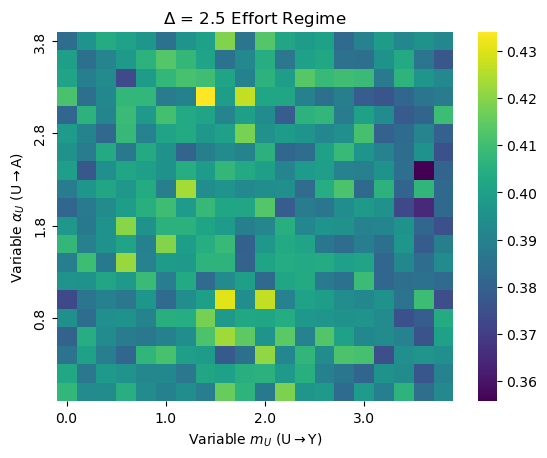

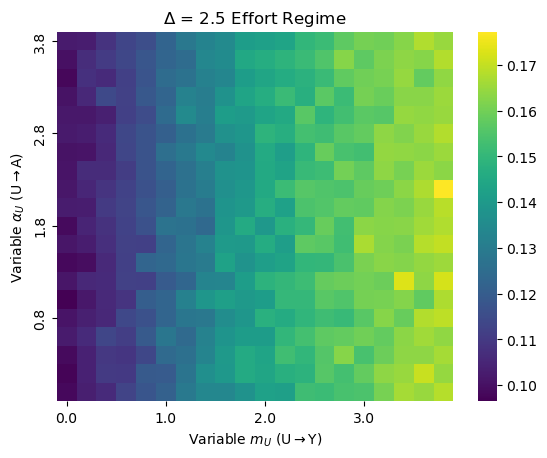

In [32]:
ei_data_test["covariance_A_Y"] = np.array(ei_data_test["covariance_A_Y"])
ei_data_test["covariance_C_Y"] = np.array(ei_data_test["covariance_C_Y"])
ei_data_test["covariance_U_Y"] = np.array(ei_data_test["covariance_U_Y"])

graph.heat_map_effort(sim_params = simulation_params, 
                        results = ei_data_test["covariance_A_Y"][:,:,0], 
                        type_graph = "covariance_A_0", delta = None, save=save_img)

graph.heat_map_effort(sim_params = simulation_params, 
                        results = ei_data_test["covariance_A_Y"][:,:,1], 
                        type_graph = "covariance_A_1", delta = None, save=save_img)

graph.heat_map_effort(sim_params = simulation_params, 
                        results = ei_data_test["covariance_C_Y"][:,:,0], 
                        type_graph = "covariance_C_0", delta = None, save=save_img)

graph.heat_map_effort(sim_params = simulation_params, 
                        results = ei_data_test["covariance_C_Y"][:,:,1], 
                        type_graph = "covariance_C_1", delta = None, save=save_img)

graph.heat_map_effort(sim_params = simulation_params, 
                        results = ei_data_test["covariance_U_Y"][:,:,0], 
                        type_graph = "covariance_U_0", delta = None, save=save_img)


graph.heat_map_effort(sim_params = simulation_params, 
                        results = ei_data_test["covariance_U_Y"][:,:,1], 
                        type_graph = "covariance_U_1", delta = None, save=save_img)




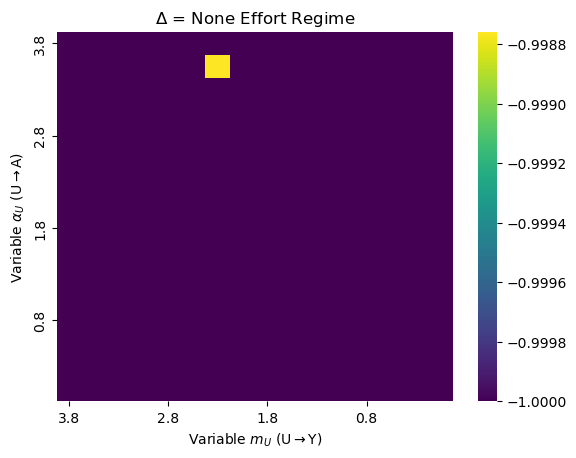

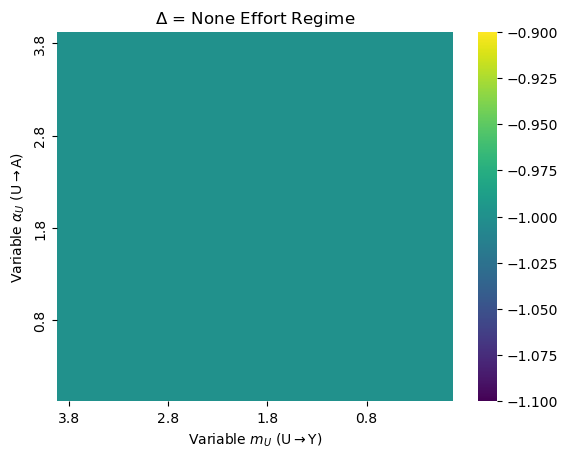

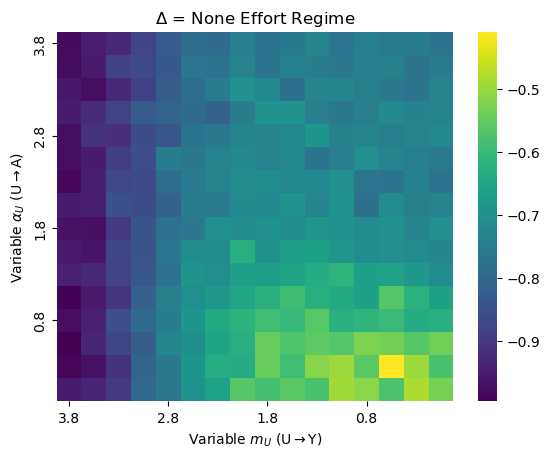

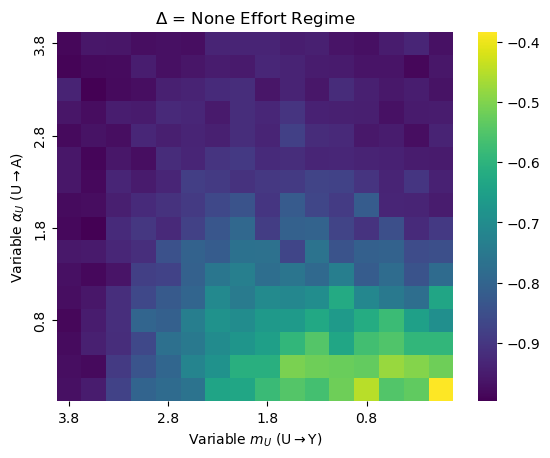

In [41]:
ei_data_test["pred_feature_improved"] = np.array(ei_data_test["pred_feature_improved"])
ei_data_test["real_feature_improved"] = np.array(ei_data_test["real_feature_improved"])

graph.heat_map_effort(sim_params = simulation_params, 
                        results = ei_data_test["pred_feature_improved"][:,:,0], 
                        type_graph = "pred_feature_improve_0", delta = None, save=save_img)

graph.heat_map_effort(sim_params = simulation_params, 
                        results = ei_data_test["pred_feature_improved"][:,:,1], 
                        type_graph = "pred_feature_improve_1", delta = None, save=save_img)

graph.heat_map_effort(sim_params = simulation_params, 
                        results = ei_data_test["real_feature_improved"][:,:,0], 
                        type_graph = "real_feature_improve_0", delta = None, save=save_img)

graph.heat_map_effort(sim_params = simulation_params, 
                        results = ei_data_test["real_feature_improved"][:,:,1], 
                        type_graph = "real_feature_improve_1", delta = None, save=save_img)



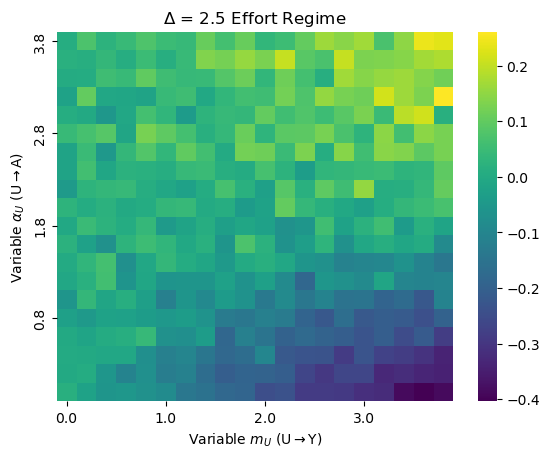

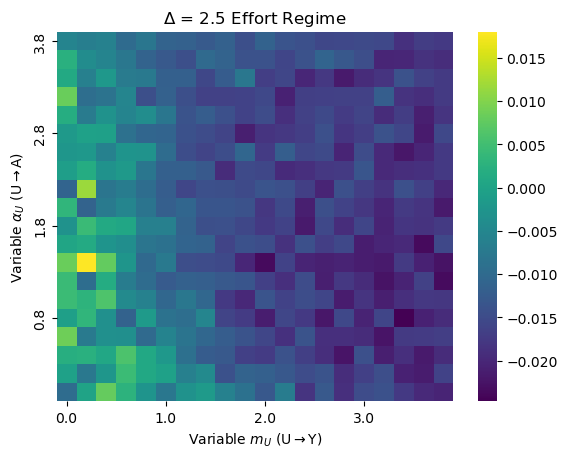

In [34]:
'''all_improve_heat_map_effort(ei_data_test["pred_delta_improv"][:,:,0], 
                              simulation_gaming["vars_0"], labels[simulation_gaming["str_vars"][0]], 
                              simulation_gaming["vars_1"], labels[simulation_gaming["str_vars"][1]], 
                              simulation_gaming["type_effort"], "pred_delta_0", delta)
all_improve_heat_map_effort(ei_data_test["pred_delta_improv"][:,:,1], 
                              simulation_gaming["vars_0"], labels[simulation_gaming["str_vars"][0]], 
                              simulation_gaming["vars_1"], labels[simulation_gaming["str_vars"][1]], 
                              simulation_gaming["type_effort"], "pred_delta_1", delta)

all_improve_heat_map_effort(ei_data_test["real_delta_improv"][:,:,0], 
                              simulation_gaming["vars_0"], labels[simulation_gaming["str_vars"][0]], 
                              simulation_gaming["vars_1"], labels[simulation_gaming["str_vars"][1]], 
                              simulation_gaming["type_effort"], "real_delta_0", delta)
all_improve_heat_map_effort(ei_data_test["real_delta_improv"][:,:,1], 
                             simulation_gaming["vars_0"], labels[simulation_gaming["str_vars"][0]], 
                              simulation_gaming["vars_1"], labels[simulation_gaming["str_vars"][1]], 
                              simulation_gaming["type_effort"], "real_delta_1", delta)
'''

graph.all_improve_heat_map_effort(ei_data_test["pred_delta_improv"][:,:,0] - ei_data_test["real_delta_improv"][:,:,0], 
                              simulation_gaming["vars_0"], labels[simulation_gaming["str_vars"][0]], 
                              simulation_gaming["vars_1"], labels[simulation_gaming["str_vars"][1]], 
                              simulation_gaming["type_effort"], "pred_delta_0", delta, save=False)
graph.all_improve_heat_map_effort(ei_data_test["pred_delta_improv"][:,:,1] - ei_data_test["real_delta_improv"][:,:,1], 
                              simulation_gaming["vars_0"], labels[simulation_gaming["str_vars"][0]], 
                              simulation_gaming["vars_1"], labels[simulation_gaming["str_vars"][1]], 
                              simulation_gaming["type_effort"], "pred_delta_1", delta, save=False)



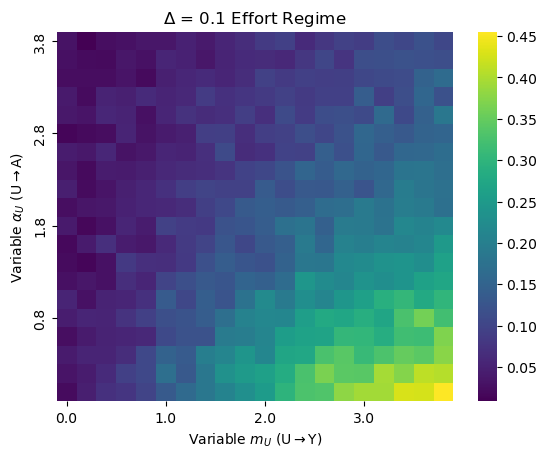

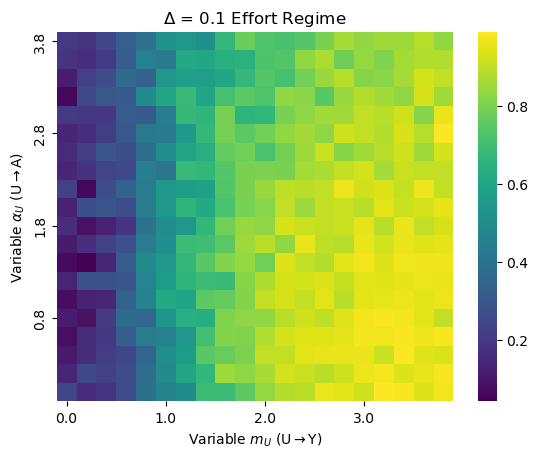

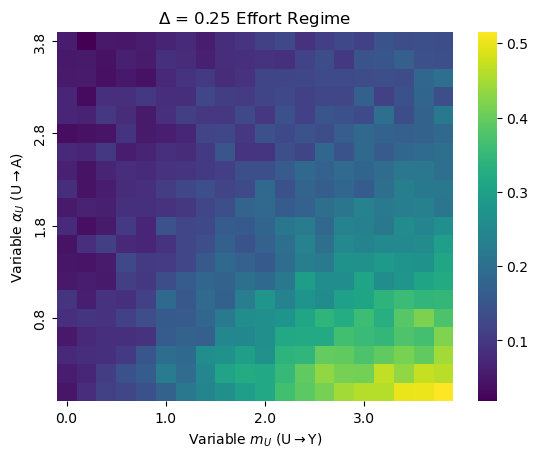

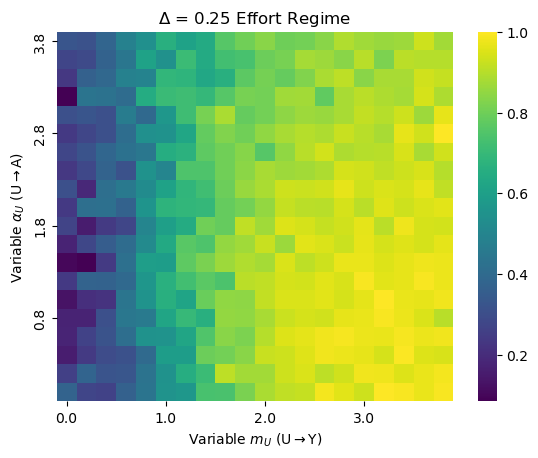

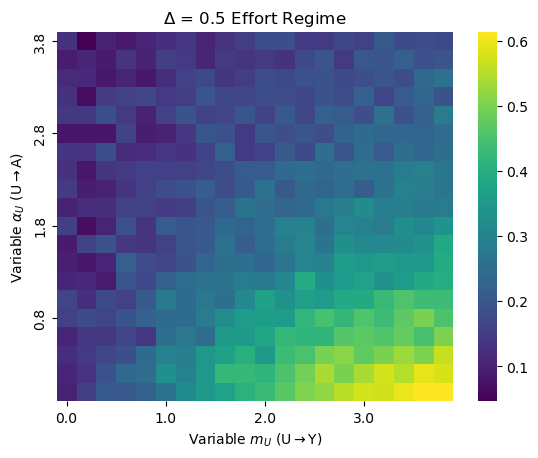

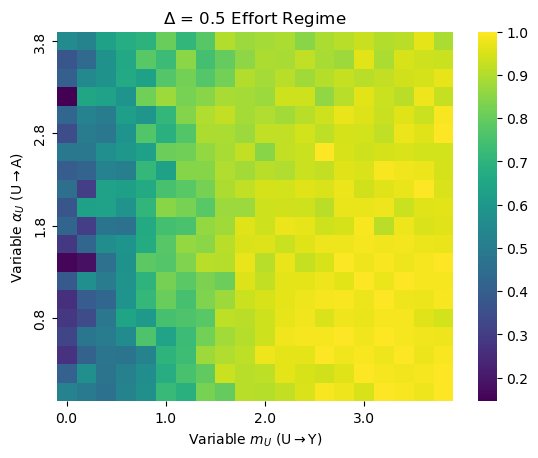

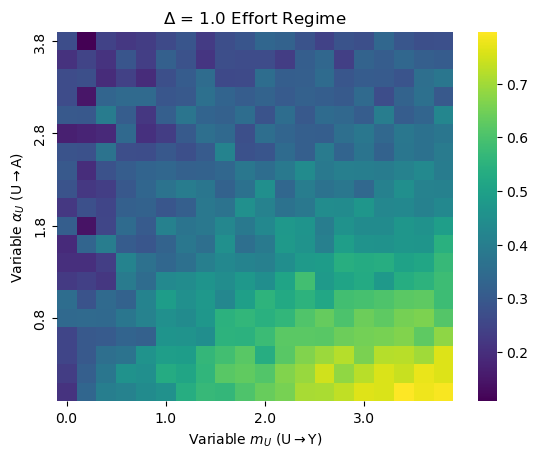

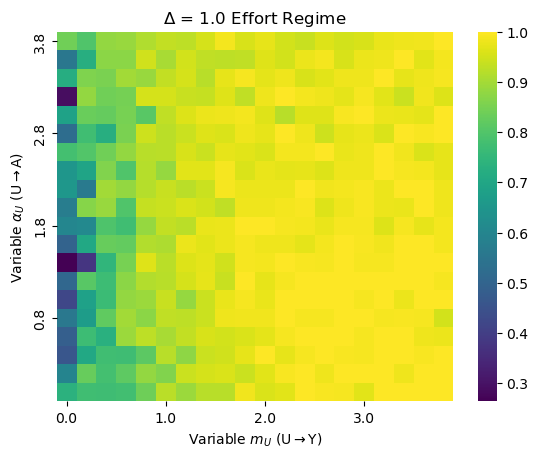

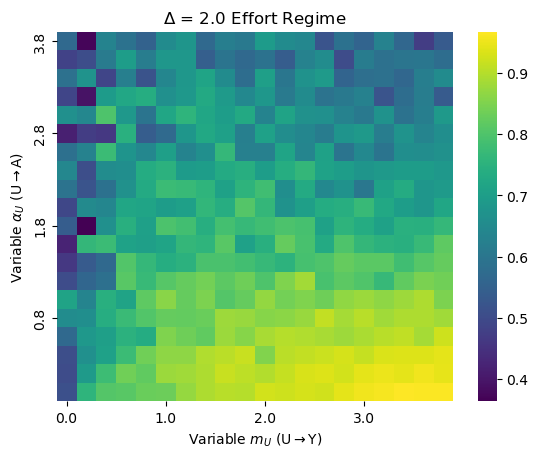

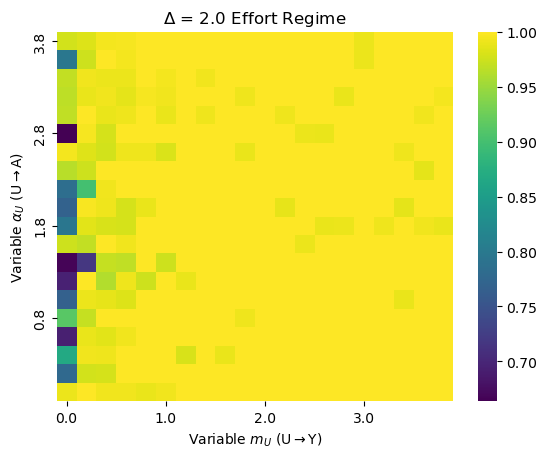

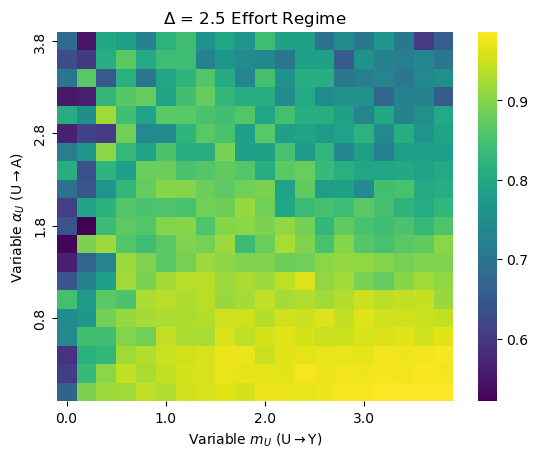

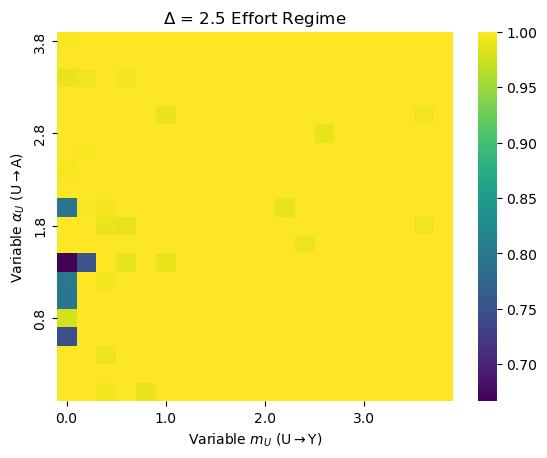

In [35]:
#DIFF IN IMPROVABILITY GRAPHS
for d, delta in enumerate(simulation_gaming["deltas"]):
  #print(ei_data_SY_test["ei_data"][d])
  #print(ei_data_SY_test["mask"][d])
  graph.all_improve_heat_map_effort(ei_data_test["gaming_data"][d][:,:,0], 
                              simulation_gaming["vars_0"], labels[simulation_gaming["str_vars"][0]], 
                              simulation_gaming["vars_1"], labels[simulation_gaming["str_vars"][1]], 
                              simulation_gaming["type_effort"][d], "Gaming_0", delta, save=save_img)
  graph.all_improve_heat_map_effort(ei_data_test["gaming_data"][d][:,:,1], 
                             simulation_gaming["vars_0"], labels[simulation_gaming["str_vars"][0]], 
                              simulation_gaming["vars_1"], labels[simulation_gaming["str_vars"][1]], 
                              simulation_gaming["type_effort"][d], "Gaming_1", delta, save=save_img)

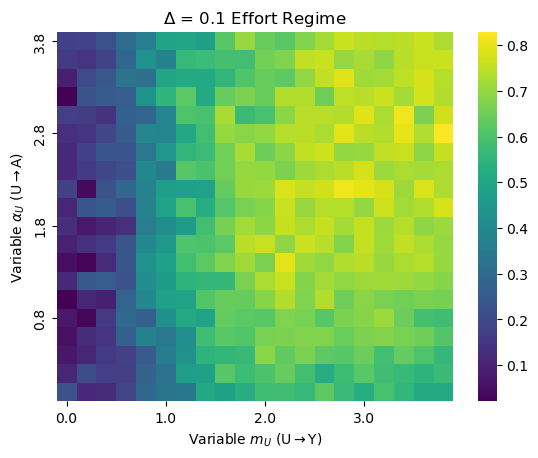

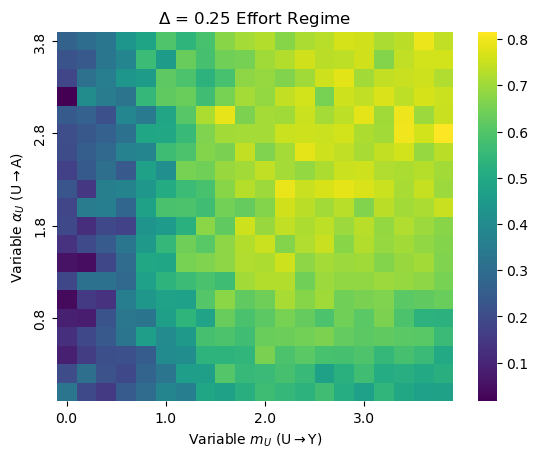

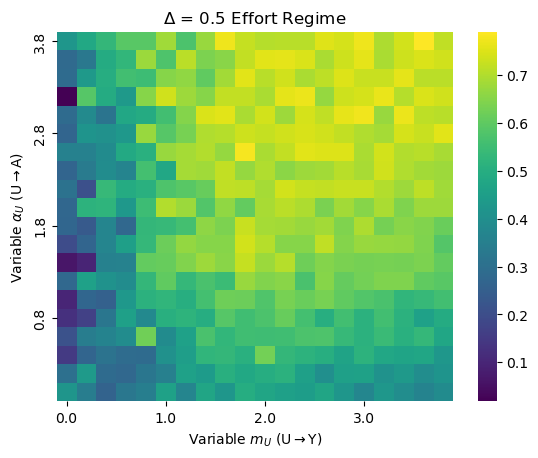

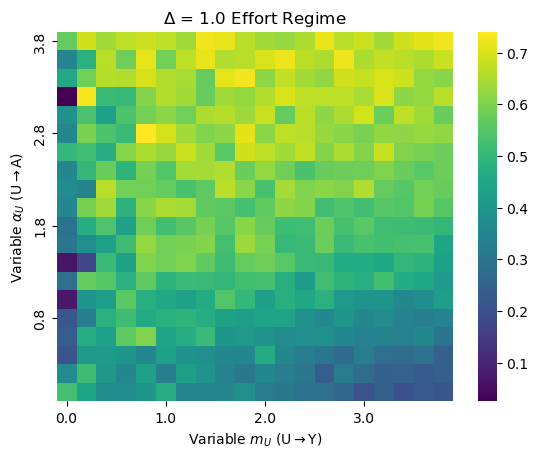

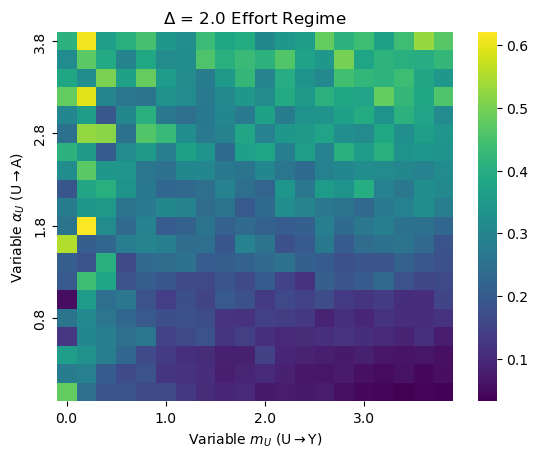

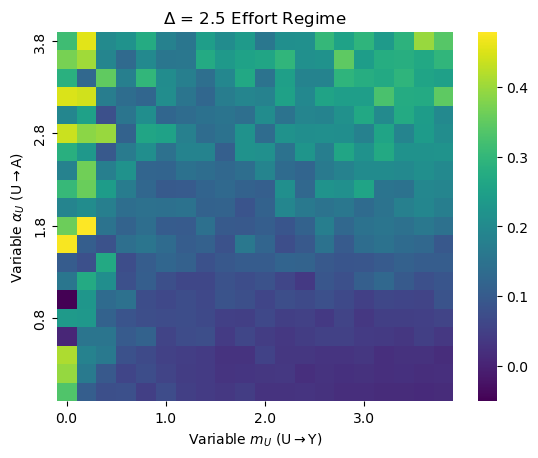

In [36]:
#DIFF IN IMPROVABILITY GRAPHS
for d, delta in enumerate(simulation_gaming["deltas"]):
  #print(ei_data_SY_test["ei_data"][d])
  #print(ei_data_SY_test["mask"][d])
  graph.all_improve_heat_map_effort(ei_data_test["gaming_data"][d][:,:,1] - ei_data_test["gaming_data"][d][:,:,0], 
                              simulation_gaming["vars_0"], labels[simulation_gaming["str_vars"][0]], 
                              simulation_gaming["vars_1"], labels[simulation_gaming["str_vars"][1]], 
                              simulation_gaming["type_effort"][d], "Gaming_diff", delta, save=save_img)


In [ ]:
#DIFF IN IMPROVABILITY GRAPHS
for u in range(2):
  for d, delta in enumerate(simulation_gaming["deltas"]):
  #print(ei_data_SY_test["ei_data"][d])
  #print(ei_data_SY_test["mask"][d])
    graph.all_improve_heat_map_effort(ei_data_test["gaming_data_U"][d][:,:,u,0], 
                              simulation_gaming["vars_0"], labels[simulation_gaming["str_vars"][0]], 
                              simulation_gaming["vars_1"], labels[simulation_gaming["str_vars"][1]], 
                              simulation_gaming["type_effort"][d], "Gaming_u"+str(u)+"_s0", delta, save=save_img)
    graph.all_improve_heat_map_effort(ei_data_test["gaming_data_U"][d][:,:,u,1], 
                             simulation_gaming["vars_0"], labels[simulation_gaming["str_vars"][0]], 
                              simulation_gaming["vars_1"], labels[simulation_gaming["str_vars"][1]], 
                              simulation_gaming["type_effort"][d], "Gaming_u"+str(u)+"_s1", delta, save=save_img)
    graph.all_improve_heat_map_effort(ei_data_test["gaming_data_U"][d][:,:,u,1] - ei_data_test["gaming_data_U"][d][:,:,u,0], 
                              simulation_gaming["vars_0"], labels[simulation_gaming["str_vars"][0]], 
                              simulation_gaming["vars_1"], labels[simulation_gaming["str_vars"][1]], 
                              simulation_gaming["type_effort"][d], "Gaming_u"+str(u)+"_diff", delta, save=save_img)


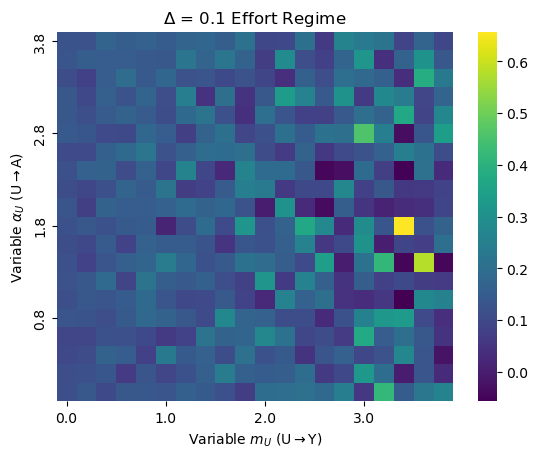

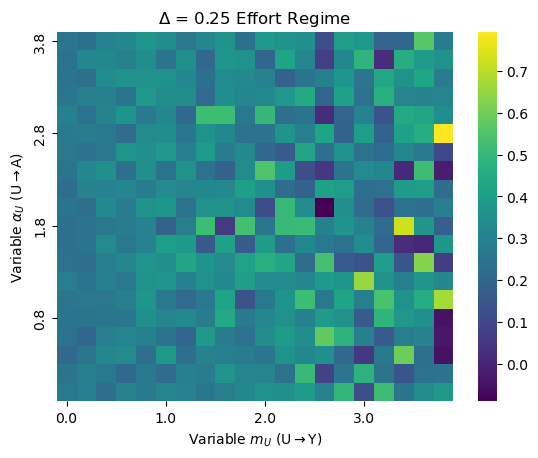

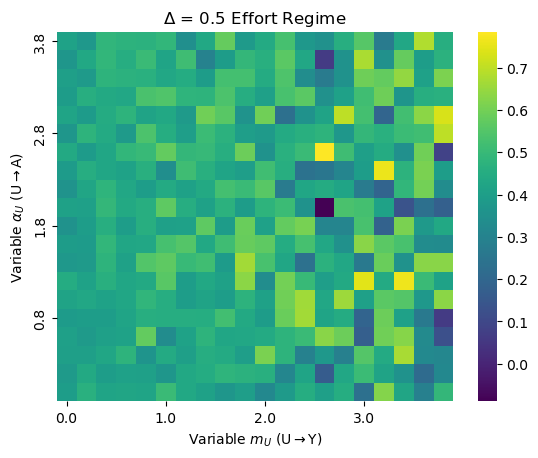

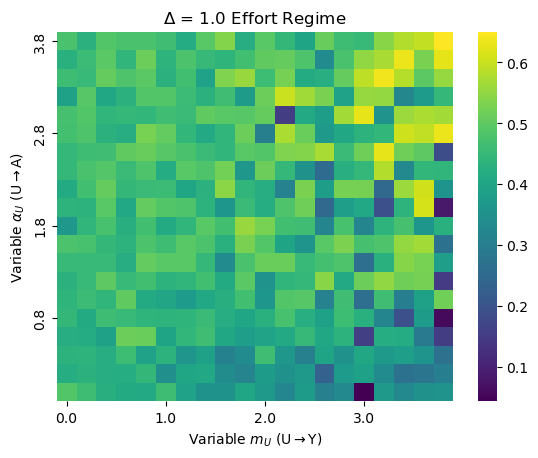

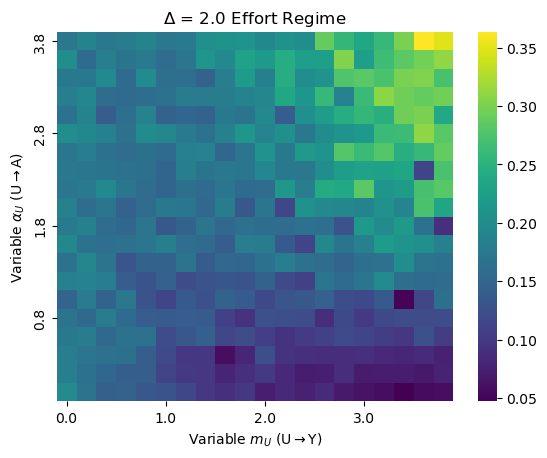

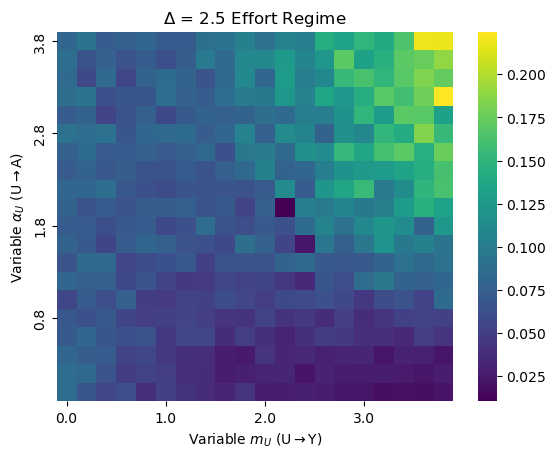

In [37]:
#DIFF IN IMPROVABILITY GRAPHS
for d, delta in enumerate(simulation_gaming["deltas"]):
  #print(ei_data_SY_test["ei_data"][d])
  #print(ei_data_SY_test["mask"][d])
  graph.all_improve_heat_map_effort(ei_data_test["ei_data"][d][:,:,1]- ei_data_test["ei_data"][d][:,:,0], 
                              simulation_gaming["vars_0"], labels[simulation_gaming["str_vars"][0]], 
                              simulation_gaming["vars_1"], labels[simulation_gaming["str_vars"][1]], 
                              simulation_gaming["type_effort"][d], "ei_data", delta)
